In [1]:
import copy
from datetime import datetime
import os
import pickle
import sys
import time
sys.path.append('/home/diego/python/generative-glm/experiments/')
# sys.path.append('/home/diego/Dropbox/hold_noise/mpl_styles/')

import h5py
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import pandas as pd
import scipy.io
import seaborn as sns
import torch
from torch.optim import Adam
# import seaborn as sns

from gglm.glm.cimmdglm import CIMMDGLM
from gglm.glm.torchglm import TorchGLM
from gglm.metrics import bernoulli_log_likelihood_poisson_process, time_rescale_transform
from gglm.utils import shift_array

from kernel.fun import KernelFun
from kernel.rect import KernelRect
from kernel.values import KernelBasisValues

from sptr.sptr import SpikeTrain

from signals import auto_covariance

import myplt

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
from nips import *
for key, val in paper.items():
    mpl.rcParams[key] = val
palette = dict(d='C0', ml='C2', mmd='C1', chen='C4', l2='C9')

In [2]:
server_name = os.uname()[1]
print(server_name)
from IPython.display import Javascript
Javascript('document.title="{}"'.format(server_name))

cypress


<IPython.core.display.Javascript object>

In [3]:
# matplotlib.rcParams['svg.fonttype'] = 'none'

(<Figure size 576x576 with 10 Axes>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x7f42a72b0700>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7f42a6f735b0>))

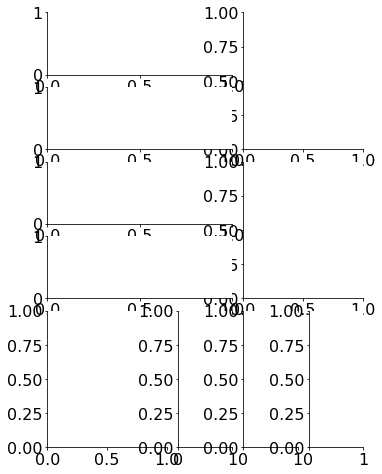

In [23]:
def plot_layout(f):
    r1, r2, r3 = 1, 2, 2
    c1, c2, c3 = 3, 2, 1
    nrows = 3 * r2
    ncols = c1 + 2 * c2
    fig = plt.figure(figsize=(1 * f, 1 * f))
    ax00 = plt.subplot2grid((nrows, ncols), (0, 0), rowspan=r1, colspan=c1)
    ax01 = plt.subplot2grid((nrows, ncols), (0, c1), rowspan=r2, colspan=c2)
    ax10 = plt.subplot2grid((nrows, ncols), (r1, 0), rowspan=r1, colspan=c1, sharex=ax00)
    ax20 = plt.subplot2grid((nrows, ncols), (2 * r1, 0), rowspan=r1, colspan=c1, sharex=ax00)
    ax21 = plt.subplot2grid((nrows, ncols), (2 * r1, c1), rowspan=r2, colspan=c2)
    ax30 = plt.subplot2grid((nrows, ncols), (3 * r1, 0), rowspan=r1, colspan=c1, sharex=ax00)
    ax40 = plt.subplot2grid((nrows, ncols), (4 * r1, 0), rowspan=r2, colspan=c2)
    ax41 = plt.subplot2grid((nrows, ncols), (4 * r1, c2), rowspan=r3, colspan=c3)
    ax42 = plt.subplot2grid((nrows, ncols), (4 * r1, c2 + 1), rowspan=r3, colspan=c3)
    ax43 = plt.subplot2grid((nrows, ncols), (4 * r1, c2 + 2), rowspan=r3, colspan=c3)
    return fig, (ax00, ax01, ax10, ax20, ax21, ax30, ax40, ax41, ax42, ax43)

def plot_layout2():
    fig = plt.figure(figsize=(12, 10))
    ax00 = plt.subplot2grid((nrows, ncols), (0, 0), rowspan=r1)
    ax01 = plt.subplot2grid((nrows, ncols), (0, 1), rowspan=r1, sharex=ax00)
    ax02 = plt.subplot2grid((nrows, ncols), (0, 2), rowspan=r1, sharex=ax00)
    ax03 = plt.subplot2grid((nrows, ncols), (0, 3), rowspan=r1)
    ax10 = plt.subplot2grid((nrows, ncols), (r1, 0), colspan=ncols - 1)
    ax11 = plt.subplot2grid((nrows, ncols), (r1, ncols - 1), colspan=1)
    ax20 = plt.subplot2grid((nrows, ncols), (r1 + r2, 0), colspan=ncols - 1, sharex=ax10)
    ax21 = plt.subplot2grid((nrows, ncols), (r1 + r2, ncols - 1), colspan=1, sharex=ax11, sharey=ax11)
    ax30 = plt.subplot2grid((nrows, ncols), (r1 + 2*r2, 0), colspan=ncols - 1, sharex=ax10)
    ax40 = plt.subplot2grid((nrows, ncols), (r1 + 3*r2, 0), rowspan=r1)
    ax41 = plt.subplot2grid((nrows, ncols), (r1 + 3*r2, 1), rowspan=r1)
    ax42 = plt.subplot2grid((nrows, ncols), (r1 + 3*r2, 2), rowspan=r1)
    ax43 = plt.subplot2grid((nrows, ncols), (r1 + 3*r2, 3), rowspan=r1)
    return fig, (ax00, ax01, ax02, ax03, ax10, ax11, ax20, ax21, ax30, ax40, ax41, ax42, ax43)

def plot_layout3(f):
    r1, r2, r3 = 1, 2, 1
    c1, c2, c3 = 3, 2, 1
    nrows = 2 * r2
    ncols = c1 + 2 * c2
    fig = plt.figure(figsize=(2 * f, 1 * f))
    ax00 = plt.subplot2grid((nrows, ncols), (0, 0), rowspan=r1, colspan=c1)
    ax01 = plt.subplot2grid((nrows, ncols), (0, c1), rowspan=r3, colspan=c3)
    ax01b = plt.subplot2grid((nrows, ncols), (r1, c1), rowspan=r3, colspan=c3)
    ax01c = plt.subplot2grid((nrows, ncols), (0, c1 + c3), rowspan=1, colspan=c3)
    ax02 = plt.subplot2grid((nrows, ncols), (0, c1 + 2 * c3), rowspan=r2, colspan=c2)
#     ax02 = plt.subplot2grid((nrows, ncols), (0, c1 +  2 * c3), rowspan=r2, colspan=c2)
    ax10 = plt.subplot2grid((nrows, ncols), (r1, 0), rowspan=r1, colspan=c1, sharex=ax00)
    ax20 = plt.subplot2grid((nrows, ncols), (2 * r1, 0), rowspan=r1, colspan=c1, sharex=ax00)
    ax21 = plt.subplot2grid((nrows, ncols), (2 * r1, c1), rowspan=r2, colspan=c2)
    ax22 = plt.subplot2grid((nrows, ncols), (2 * r1, c1 + c2), rowspan=r2, colspan=c2)
    ax30 = plt.subplot2grid((nrows, ncols), (3 * r1, 0), rowspan=r1, colspan=c1, sharex=ax00)
    return fig, (ax00, ax01, ax01b, ax01c, ax02, ax10, ax20, ax21, ax22, ax30)

def plot_layout_rebuttal(f):
    r1, r2 = 2, 1
#     c1, c2, c3 = 3, 2, 1
    nrows = 2
    ncols = 3
    fig = plt.figure(figsize=(3 * f, 1 * f))
    axeta = plt.subplot2grid((nrows, ncols), (0, 0), rowspan=r1)
    axac = plt.subplot2grid((nrows, ncols), (0, 1), rowspan=r1)
    axmmd = plt.subplot2grid((nrows, ncols), (0, 2), rowspan=r2)
    axll = plt.subplot2grid((nrows, ncols), (1, 2), rowspan=r2, sharex=axmmd)
    return fig, (axeta, axac, axmmd, axll)

def plot_layout_rebuttal2(f):
    c1, c2 = 2, 1
    nrows = 1
    ncols = 6
    fig = plt.figure(figsize=(3 * f, 1 * f))
    axeta = plt.subplot2grid((nrows, ncols), (0, 0), colspan=c1)
    axac = plt.subplot2grid((nrows, ncols), (0, c1), colspan=c1)
    axmmd = plt.subplot2grid((nrows, ncols), (0, 2 * c1), colspan=c2)
    axll = plt.subplot2grid((nrows, ncols), (0, 2 * c1 + c2), colspan=c2, sharex=axmmd)
    return fig, (axeta, axac, axmmd, axll)

plot_layout(8)

## define basis

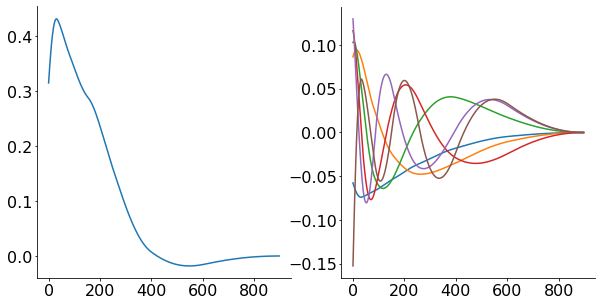

In [5]:
from scipy.io import loadmat
basis = loadmat('./monkey_basis.mat')['a']

# eta = KernelBasisValues(X_eta, [0, 1000], 1, coefs=[-5, 1, -0.75, 0.5, -0.2,  0.1, -0.05])
t_ker = np.arange(0, basis.shape[0], 1)
eta = KernelBasisValues(basis, [0, basis.shape[0]], 1, coefs=[-5, 1, -0.75, 0.5, -0.2,  0.1])
eta_vals = eta.interpolate(np.arange(0, 898, 1))
fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), ncols=2)
ax1.plot(eta_vals)
ax2.plot(basis)

# args = np.where(shift_array(mask_spikes_train, 1, fill_value=False))
# t_spk = (t[args[0]],) + args[1:]
# X = eta.convolve_basis_discrete(t, t_spk, shape=mask_spikes_train.shape)
# fig, ax = plt.subplots()
# ax.plot(X[:, 0, :])

In [6]:
# def raised_cosine(t, b, c, dc, a=1e0):
#     basis = (1 + np.cos(np.maximum(-np.pi, np.minimum(a * (np.log(t + b) - c) * np.pi / dc / 2, np.pi)))) / 2
#     basis = basis / np.sqrt(np.sum(basis**2, 0))
#     u, s, v = np.linalg.svd(basis)
#     basis = u[:, :basis.shape[1]]
#     return basis

# # n = 6
# # last_peak = 400
# # b = last_peak / 5
# # peak0 = 0

# n = 6
# last_peak = 200
# b = last_peak / 7
# peak0 = 0

# yrnge = np.log(np.array([0, last_peak]) + b)
# db = np.diff(yrnge) / (n - 1)
# ctrs = np.arange(yrnge[0], yrnge[1] + db, db)
# mxt = np.exp(yrnge[1] + 2 * db) - b # max time bin
# print(mxt[-1])
# t_ker = np.arange(0, mxt[-1], dt)

# basis = raised_cosine(t_ker[:, None], b, ctrs[None, :], db)

# fig, ax = plt.subplots(figsize=(12, 5))
# ax.plot(t_ker, basis)

## load data

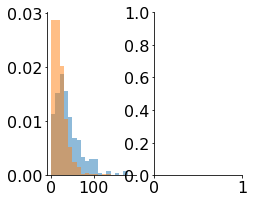

In [7]:
path = "/home/diego/python/generative-glm/experiments/figure3/monkey_pmv.h5"
f = h5py.File(path, "r")

arg_spikes = (np.array(f['MC']['spikeTimes'], dtype=int)[:, 0], np.array(f['MC']['spikeIndices'], dtype=int)[:, 0] - 1)

dt = 1
t = np.arange(0, 1000, dt)
mask_spikes = np.zeros((len(t), 10), dtype=bool)
mask_spikes[arg_spikes] = True

n_train = 10
mask_spikes_train = mask_spikes[:, :n_train]
n_spk_train = np.sum(mask_spikes_train)
fr_train = np.mean(np.sum(mask_spikes_train, 0) / (t[-1] - t[0] + t[1]) * 1000)
nll_pois_proc_train = -bernoulli_log_likelihood_poisson_process(mask_spikes_train)
autocov_train = np.mean(auto_covariance(mask_spikes_train, method='fft', subtract_mean=False, 
                                        stationary_signal=False, biased=False), 1)
# mask_spikes_val = mask_spikes[:, n_train:]
# fr_val = np.mean(np.sum(mask_spikes_val, 0) / (t[-1] - t[0] + t[1]) * 1000)

# mask_inh = np.array(loadmat('./monkey_pmv_inhomo.mat')['pseudo_all_spike_trainInHomo'].T, dtype=bool)
mask_inh = np.array(loadmat('./monkey_pmv_inh.mat')['pseudo_all_spike_trainInHomo'].T, dtype=bool)
st_inh = SpikeTrain(np.arange(0, mask_inh.shape[0], 1), mask_inh)
isi_inh = st_inh.isi_distribution()
autocov_inh = np.mean(auto_covariance(mask_inh, method='fft', subtract_mean=False, 
                                        stationary_signal=False, biased=False), 1)

st_train = SpikeTrain(t, mask_spikes_train)
isi_train = st_train.isi_distribution()
mean_isi_train = np.mean(isi_train)
bins = np.arange(0, 200, 10)
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.hist(isi_train, density=True, bins=bins, alpha=0.5)
ax1.hist(isi_inh, density=True, bins=bins, alpha=0.5)

# st_val = SpikeTrain(t, mask_spikes_val)
# isi_val = st_val.isi_distribution()
# mean_isi_val = np.mean(isi_val)

n_samples = 400
argf_autocor = 100
t_long = np.arange(0, 3000, 1)

padding = 100

conv_ker = KernelFun.gaussian_delta(20)

psth_d = np.mean(st_train.convolve(conv_ker), 1) * 1000

### kernels

In [8]:
from torch.nn.functional import conv1d

def phi_id(t, r):
    return r * 1000

def kernel_id(t, r1, r2):
    return torch.sum(r1[:, :, None] * 1000 * r2[:, None, :] * 1000, 0)

def phi_mean(t, r):
    return torch.mean(r, 0)[None, :] * 1000

def phi_sum(t, r):
    return torch.sum(r  * 1000, 0)[None, :]

def phi_autocov(t, r, model, padding=100):
    T = len(t)
    eta = torch.log(r) - model.b.detach()
#     padding = 100
    autocov = conv1d(eta.T[None, :, :], eta.T[:, None, :], padding=padding, groups=eta.shape[1]) / T
    autocov = autocov[0, :, (padding - 1):].T
    return autocov
    
def kernel_expr(t, r1, r2):
    gramian = torch.exp(-torch.sum((r1[:, :, None] - r2[:, None, :])**2, 0) / sd2)
#     print(torch.sum((r1[:, :, None] - r2[:, None, :])**2, 0))
#     print(gramian)
    return gramian

dic_ker_strings = {'phi_id': "<r,r'>", 'phi_mean': "mu_r * mu_r'", 'phi_sum': "sum_r * sum_r'", 
                   'kernel_expr': "exp(-sum((r-r')^2)/sd^2)", 'kernel_id': "<r,r'>", 'phi_autocov': "<g, g'>"}
dic_ker_name = {'phi_id': "canonical_dot", 'phi_mean': 'means_product', 'phi_sum': "sum_product", 
               'kernel_expr': "gaussian", 'kernel_id': "canonical_dot", 'phi_autocov': "autocov"}

## contents <a name="contents"></a>  

[ML](#ml)  
[CIMMD](#mmd)  
[paper_figure](#paper_figure)  

### ML <a name="ml"></a>  

In [22]:
def fun_metrics_ml(model, t, mask_spikes, X):
    n_batch_fr = 25
    T = st_train.t[-1] - st_train.t[0] + st_train.t[1]
    u_fr, r_fr, mask_spikes_fr = model.sample(st_train.t, shape=(n_batch_fr,))
    fr = np.sum(mask_spikes_fr, 0) / T * 1000
    mu_fr = np.mean(fr)
    return dict(mu_fr=mu_fr)

In [23]:
coefs = np.zeros(basis.shape[1])
eta0 = KernelBasisValues(basis.copy(), [0, basis.shape[0]], 1, coefs=coefs)

lr = 1e-1
num_epochs = 200
n_metrics = 10

glm = TorchGLM(u0=-5, eta=eta0.copy(), noise='bernoulli')
optim = Adam(glm.parameters(), lr=lr)
loss_ml, metrics_ml = glm.train(st_train.t, st_train.mask, optim=optim, num_epochs=num_epochs, 
                                verbose=True, metrics=fun_metrics_ml, n_metrics=n_metrics)
iterations_ml = np.arange(1, num_epochs + 1, 1)
nll_normed_train_ml = (loss_ml - nll_pois_proc_train) / np.log(2) / n_spk_train

_, r_train_dc_ml = glm.sample_conditioned(st_train.t, st_train.mask)
# _, r_fr_ml, mask_spikes_fr_ml = glm.sample(st_train.t, shape=(st_train.mask.shape[1],))
# _, r_fr_ml, mask_spikes_fr_ml = glm.sample(st_train.t, shape=(200,))
# r_fr_ml = r_fr_ml * 1000
# st_fr_ml = SpikeTrain(st_train.t, mask_spikes_fr_ml)
# isi_fr_ml = st_fr_ml.isi_distribution()
# mean_isi_fr_ml = np.mean(isi_fr_ml)
# mean_r_fr_ml = np.mean(r_fr_ml, 1)
# sum_r_fr_ml = np.sum(r_fr_ml, 1)

# _, r_fr_ml_long, mask_spikes_fr_ml_long = glm.sample(t_long, shape=(10,))
_, r_fr_ml_long, mask_spikes_fr_ml_long = glm.sample(t_long, shape=(8000,))
st_fr_ml_long = SpikeTrain(t_long, mask_spikes_fr_ml_long)
psth_ml = np.mean(st_fr_ml_long.convolve(conv_ker), 1) * 1000
isi_fr_ml_long = st_fr_ml_long.isi_distribution()
mean_isi_fr_ml_long = np.mean(isi_fr_ml_long)
# _, _, mask_autocov = glm.sample(t_long, shape=(400,))
fr_ml = np.sum(mask_spikes_fr_ml_long, 0) / (t_long[-1] + dt) * 1000
fr_sd_ml = np.std(fr_ml)# / np.sqrt(len(fr_ml))
fr_mu_ml = np.mean(fr_ml)
autocov_ml_long = np.mean(auto_covariance(mask_spikes_fr_ml_long, method='fft', 
                                           subtract_mean=False, stationary_signal=False, biased=False), 1)
z_ml, ks_ml = time_rescale_transform(dt, st_train.mask, r_train_dc_ml)
values, bins_ks = np.histogram(np.concatenate(z_ml), bins=100)
z_cum_ml = np.append(0., np.cumsum(values) / np.sum(values))

phi_d_ml = phi_autocov(t, torch.from_numpy(r_train_dc_ml), glm, padding=padding)
phi_fr_ml = phi_autocov(t, torch.from_numpy(r_fr_ml_long[:len(t)]), glm, padding=padding)
mmd_ml = (torch.sum((torch.mean(phi_d_ml.detach(), 1) - torch.mean(phi_fr_ml.detach(), 1))**2)).item()

 epoch 199 of 200 loss 1112.0382

35.32641666666667


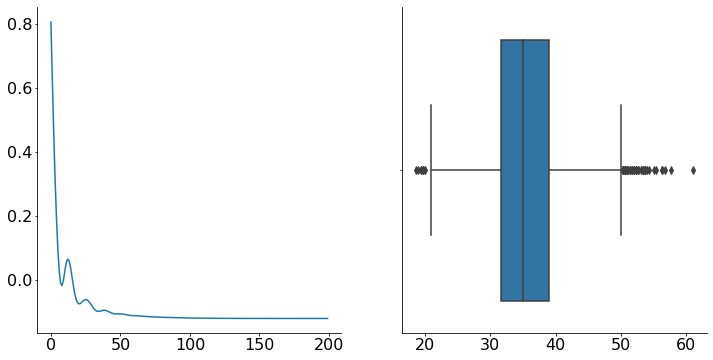

In [24]:
print(fr_mu_ml)
fig, (ax1, ax2) = plt.subplots(figsize=(12, 6), ncols=2)
ax1.plot(nll_normed_train_ml)
sns.boxplot(fr_ml, ax=ax2)

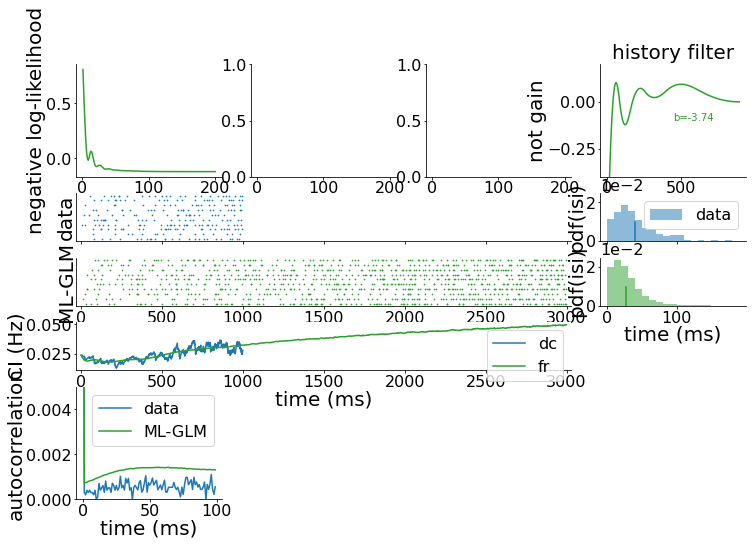

In [25]:
for key, val in metrics_ml.items():
    metrics_ml[key] = np.array(val)

ncols = 4
r1, r2 = 2, 1
nrows = 2 * r1 + 3 * r2

fig = plt.figure(figsize=(12, 8))
ax00 = plt.subplot2grid((nrows, ncols), (0, 0), rowspan=r1)
ax01 = plt.subplot2grid((nrows, ncols), (0, 1), rowspan=r1, sharex=ax00)
ax02 = plt.subplot2grid((nrows, ncols), (0, 2), rowspan=r1, sharex=ax00)
ax03 = plt.subplot2grid((nrows, ncols), (0, 3), rowspan=r1)
ax10 = plt.subplot2grid((nrows, ncols), (r1, 0), colspan=ncols - 1)
ax11 = plt.subplot2grid((nrows, ncols), (r1, ncols - 1), colspan=1)
ax20 = plt.subplot2grid((nrows, ncols), (r1 + r2, 0), colspan=ncols - 1, sharex=ax10)
ax21 = plt.subplot2grid((nrows, ncols), (r1 + r2, ncols - 1), colspan=1, sharex=ax11, sharey=ax11)
ax30 = plt.subplot2grid((nrows, ncols), (r1 + 2*r2, 0), colspan=ncols - 1, sharex=ax10)
ax40 = plt.subplot2grid((nrows, ncols), (r1 + 3*r2, 0), rowspan=r1)

ax00.plot(iterations_ml, nll_normed_train_ml, color=palette['ml'])
# ax1.plot(iterations_ml, metrics_ml['nll_val'], color=palette['ml'])
myplt.set_labels(ax00, xlabel='iterations', ylabel='negative log-likelihood')

# ax2.plot(iterations_ml[::n_metrics], metrics_ml['mu_fr'], '-.', color=palette['ml'])
# ax2.plot([1, num_epochs + 1], [fr_train, fr_train], '--', color=palette['d'], label='data')
# # ax2.set_ylim(0, 25)
# myplt.set_labels(ax2, xlabel='iterations', ylabel='samples firing rate (Hz)')
# ax2.legend()

glm.eta.plot(t=t_ker, ax=ax03, exp_values=False, color=palette['ml'])
myplt.set_labels(ax03, xlabel='time (ms)', ylabel='not gain', title='history filter')
ax03.text(0.5, 0.5, 'b=' + str(np.round(glm.u0, 2)), color=palette['ml'], transform=ax03.transAxes)
ax03.set_ylim(-0.4, 0.2)

st_train.plot(ax=ax10, ms=0.7, color=palette['d'])
ax10.tick_params(axis='both', labelbottom=False, labelleft=False)
ax10.set_yticks([])
ax10.set_ylabel('data')

# st_fr_ml.plot(ax=ax5, ms=0.7, color=palette['ml'])
st_fr_ml_long.sweeps(np.arange(10)).plot(ax=ax20, ms=0.7, color=palette['ml'])
ax20.set_yticks([])
ax20.set_ylabel('ML-GLM')

ax30.plot(t, np.mean(r_train_dc_ml, 1), color=palette['d'], label='dc')
ax30.plot(t_long, np.mean(r_fr_ml_long, 1), color=palette['ml'], label='fr')
ax30.legend()
myplt.set_labels(ax30, xlabel='time (ms)', ylabel='CI (Hz)')

ax11.hist(isi_train, density=True, alpha=0.5, color=palette['d'], label='data', bins=bins)
ax11.legend()
y1 = ax11.get_ylim()[1] / 2
ax11.plot([mean_isi_train, mean_isi_train], [0, y1], '-', color=palette['d'])
ax11.set_ylabel('pdf(isi)')
ax11.tick_params(axis='both', labelbottom=False)

ax21.hist(isi_fr_ml_long, density=True, alpha=0.5, color=palette['ml'], label='ML-GLM', bins=bins)
ax21.plot([mean_isi_fr_ml_long, mean_isi_fr_ml_long], [0, y1], '-', color=palette['ml'])
myplt.set_labels(ax21, xlabel='time (ms)', ylabel='pdf(isi)')
ax21.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

argf = 200
ax40.plot(autocov_train[:argf_autocor], color=palette['d'], label='data')
ax40.plot(autocov_ml_long[:argf_autocor], color=palette['ml'], label='ML-GLM')
ax40.set_ylim(0, 5e-3)
myplt.set_labels(ax40, xlabel='time (ms)', ylabel='autocorrelation')
ax40.legend()

fig.subplots_adjust(hspace=0.35)

# fig.savefig('/home/diego/Dropbox/generative_glm/figures/monkey_pmv/ML.pdf', transparent=True)

dic = dict(basis=basis, u0_ml=glm.u0, eta_coefs_ml=glm.eta.coefs, fr_mu_ml=fr_mu_ml, fr_sd_ml=fr_sd_ml, 
           nll_normed_train_ml=nll_normed_train_ml, r_train_dc_ml=r_train_dc_ml, r_fr_ml_long=r_fr_ml_long, z_cum_ml=z_cum_ml,
           st_fr_ml_long=st_fr_ml_long, psth_ml=psth_ml, bins_ks=bins_ks, mmd_ml=mmd_ml, padding=padding, 
           isi_fr_ml_long=isi_fr_ml_long, autocov_ml_long=autocov_ml_long, lr=lr)

path = '/home/diego/storage/generative-glm/experiments/figure3/monkey_pmv/' + 'ml.pk'
with open(path, "wb") as fit_file:
    pickle.dump(dic, fit_file)

## L2

In [16]:
path = '/home/diego/storage/generative-glm/experiments/figure3/monkey_pmv/' + 'ml.pk'
with open(path, "rb") as fit_file:
    dic_ml = pickle.load(fit_file)

u0_ml, eta_coefs_ml, bins_ks = dic_ml['u0_ml'], dic_ml['eta_coefs_ml'], dic_ml['bins_ks']
del dic_ml

eta_ml = KernelBasisValues(basis, [0, basis.shape[0]], 1, coefs=eta_coefs_ml)
glm_ml = TorchGLM(u0=u0_ml, eta=eta_ml)

In [17]:
# def fun_metrics_ml(model, t, mask_spikes, X):
#     return dict(nan=np.nan)

In [18]:
# lr = 1e-1
# num_epochs = 100
# n_metrics = 1

# # u00 = glm.u0
# # eta0 = glm.eta.copy()
# u00 = u0_ml
# eta0 = eta0 = KernelBasisValues(basis.copy(), [0, basis.shape[0]], 1, coefs=eta_coefs_ml)

# # alphas = [0, 1e-1, 5e-1, 1e0, 1.5e0, 2e0, 2.5e0, 3e0, 5e0, 1e1, 1e2]
# # alphas = [5e1, 1e2, 2e2, 4e2, 5e2, 6e2, 7.5e2, 1e3]
# alphas = [1e1]
# fr, fr_sd, ks_stat, ks_stat_sd = [], [], [], []

# for alpha_l2 in alphas:
#     glm_l2 = TorchGLM(u0=u00, eta=eta0.copy(), noise='bernoulli')
#     optim = Adam(glm_l2.parameters(), lr=lr)
#     loss_l2, metrics_l2 = glm_l2.train(st_train.t, st_train.mask, optim=optim, num_epochs=num_epochs, 
#                                     verbose=True, metrics=fun_metrics_ml, n_metrics=n_metrics, l2=True, alpha_l2=alpha_l2)

#     _, r_fr_l2_long, mask_spikes_fr_l2_long = glm_l2.sample(t_long, shape=(8000,))
#     st_fr_l2_long = SpikeTrain(t_long, mask_spikes_fr_l2_long)
#     isi_fr_l2_long = st_fr_l2_long.isi_distribution()
#     _ks, _ = ks_2samp(isi_train, isi_fr_l2_long)
#     ks_stat.append(_ks)
#     _fr = np.sum(mask_spikes_fr_l2_long, 0) / (t_long[-1] + dt) * 1000
#     _fr_sd = np.std(_fr)
#     _fr = np.mean(_fr)
#     fr.append(_fr)
#     fr_sd.append(_fr_sd)

In [19]:
# fig, ax = plt.subplots()
# ax.errorbar(alphas, fr, yerr=fr_sd / np.sqrt(1000), fmt='-o', label='L2')
# ax.plot([alphas[0], alphas[-1]], [fr_train, fr_train], 'k--', lw=0.5, label='data')
# ax.set_xlabel("alpha")
# ax.set_ylabel('firing rate (Hz)')
# ax.legend()
# fig.tight_layout()
# fig.savefig('/home/diego/fr_alpha.pdf')

In [106]:
lr = 2e-2
num_epochs = 200
n_metrics = 1

alpha_l2 = 7e0

u00 = glm_ml.u0
eta0 = glm_ml.eta.copy()
# u00 = u0_ml
# eta0 = KernelBasisValues(basis.copy(), [0, basis.shape[0]], 1, coefs=eta_coefs_ml)

glm_l2 = TorchGLM(u0=u00, eta=eta0.copy(), noise='bernoulli')
optim = Adam(glm_l2.parameters(), lr=lr, betas=(0, 0))
loss_l2, metrics_l2 = glm_l2.train(st_train.t, st_train.mask, optim=optim, num_epochs=num_epochs, 
                                verbose=True, metrics=None, n_metrics=n_metrics, l2=True, alpha_l2=alpha_l2)
iterations_l2 = np.arange(1, num_epochs + 1, 1)
nll_normed_train_l2 = (metrics_l2['nll'] - nll_pois_proc_train) / np.log(2) / n_spk_train

_, r_train_dc_l2 = glm_l2.sample_conditioned(st_train.t, st_train.mask)
_, r_fr_l2_long, mask_spikes_fr_l2_long = glm_l2.sample(t_long, shape=(8000,))
st_fr_l2_long = SpikeTrain(t_long, mask_spikes_fr_l2_long)
psth_l2 = np.mean(st_fr_l2_long.convolve(conv_ker), 1) * 1000
isi_fr_l2_long = st_fr_l2_long.isi_distribution()
mean_isi_fr_l2_long = np.mean(isi_fr_l2_long)
fr_l2 = np.sum(mask_spikes_fr_l2_long, 0) / (t_long[-1] + dt) * 1000
fr_sd_l2 = np.std(fr_l2)# / np.sqrt(len(fr_l2))
fr_mu_l2 = np.mean(fr_l2)
autocov_l2_long = np.mean(auto_covariance(mask_spikes_fr_l2_long, method='fft', 
                                           subtract_mean=False, stationary_signal=False, biased=False), 1)
z_l2, ks_l2 = time_rescale_transform(dt, st_train.mask, r_train_dc_l2)
values, _ = np.histogram(np.concatenate(z_l2), bins=bins_ks)
z_cum_l2 = np.append(0., np.cumsum(values) / np.sum(values))

phi_d_l2 = phi_autocov(t, torch.from_numpy(r_train_dc_l2), glm_l2, padding=padding)
phi_fr_l2 = phi_autocov(t, torch.from_numpy(r_fr_l2_long[:len(t)]), glm_l2, padding=padding)
mmd_l2 = (torch.sum((torch.mean(phi_d_l2.detach(), 1) - torch.mean(phi_fr_l2.detach(), 1))**2)).item()

 epoch 199 of 200 loss 1127.2504

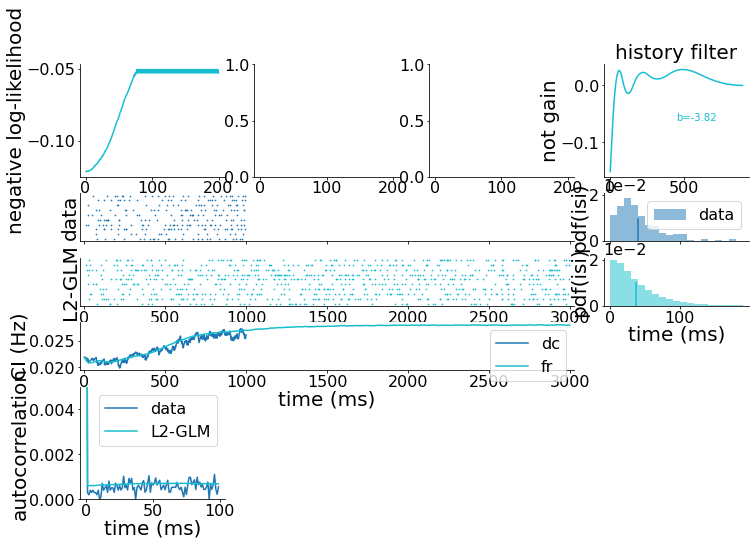

In [107]:
for key, val in metrics_l2.items():
    metrics_l2[key] = np.array(val)

ncols = 4
r1, r2 = 2, 1
nrows = 2 * r1 + 3 * r2

fig = plt.figure(figsize=(12, 8))
ax00 = plt.subplot2grid((nrows, ncols), (0, 0), rowspan=r1)
ax01 = plt.subplot2grid((nrows, ncols), (0, 1), rowspan=r1, sharex=ax00)
ax02 = plt.subplot2grid((nrows, ncols), (0, 2), rowspan=r1, sharex=ax00)
ax03 = plt.subplot2grid((nrows, ncols), (0, 3), rowspan=r1)
ax10 = plt.subplot2grid((nrows, ncols), (r1, 0), colspan=ncols - 1)
ax11 = plt.subplot2grid((nrows, ncols), (r1, ncols - 1), colspan=1)
ax20 = plt.subplot2grid((nrows, ncols), (r1 + r2, 0), colspan=ncols - 1, sharex=ax10)
ax21 = plt.subplot2grid((nrows, ncols), (r1 + r2, ncols - 1), colspan=1, sharex=ax11, sharey=ax11)
ax30 = plt.subplot2grid((nrows, ncols), (r1 + 2*r2, 0), colspan=ncols - 1, sharex=ax10)
ax40 = plt.subplot2grid((nrows, ncols), (r1 + 3*r2, 0), rowspan=r1)

ax00.plot(iterations_l2, nll_normed_train_l2, color=palette['l2'])
# ax1.plot(iterations_l2, metrics_l2['nll_val'], color=palette['l2'])
myplt.set_labels(ax00, xlabel='iterations', ylabel='negative log-likelihood')

# ax2.plot(iterations_l2[::n_metrics], metrics_l2['mu_fr'], '-.', color=palette['l2'])
# ax2.plot([1, num_epochs + 1], [fr_train, fr_train], '--', color=palette['d'], label='data')
# # ax2.set_ylim(0, 25)
# myplt.set_labels(ax2, xlabel='iterations', ylabel='samples firing rate (Hz)')
# ax2.legend()

glm_l2.eta.plot(t=t_ker, ax=ax03, exp_values=False, color=palette['l2'])
myplt.set_labels(ax03, xlabel='time (ms)', ylabel='not gain', title='history filter')
ax03.text(0.5, 0.5, 'b=' + str(np.round(glm_l2.u0, 2)), color=palette['l2'], transform=ax03.transAxes)
# ax03.set_ylim(-0.4, 0.2)

st_train.plot(ax=ax10, ms=0.7, color=palette['d'])
ax10.tick_params(axis='both', labelbottom=False, labelleft=False)
ax10.set_yticks([])
ax10.set_ylabel('data')

# st_fr_l2.plot(ax=ax5, ms=0.7, color=palette['l2'])
st_fr_l2_long.sweeps(np.arange(10)).plot(ax=ax20, ms=0.7, color=palette['l2'])
ax20.set_yticks([])
ax20.set_ylabel('L2-GLM')

ax30.plot(t, np.mean(r_train_dc_l2, 1), color=palette['d'], label='dc')
ax30.plot(t_long, np.mean(r_fr_l2_long, 1), color=palette['l2'], label='fr')
ax30.legend()
myplt.set_labels(ax30, xlabel='time (ms)', ylabel='CI (Hz)')

ax11.hist(isi_train, density=True, alpha=0.5, color=palette['d'], label='data', bins=bins)
ax11.legend()
y1 = ax11.get_ylim()[1] / 2
ax11.plot([mean_isi_train, mean_isi_train], [0, y1], '-', color=palette['d'])
ax11.set_ylabel('pdf(isi)')
ax11.tick_params(axis='both', labelbottom=False)

ax21.hist(isi_fr_l2_long, density=True, alpha=0.5, color=palette['l2'], label='L2-GLM', bins=bins)
ax21.plot([mean_isi_fr_l2_long, mean_isi_fr_l2_long], [0, y1], '-', color=palette['l2'])
myplt.set_labels(ax21, xlabel='time (ms)', ylabel='pdf(isi)')
ax21.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

ax40.plot(autocov_train[:argf_autocor], color=palette['d'], label='data')
ax40.plot(autocov_l2_long[:argf_autocor], color=palette['l2'], label='L2-GLM')
ax40.set_ylim(0, 5e-3)
myplt.set_labels(ax40, xlabel='time (ms)', ylabel='autocorrelation')
ax40.legend()

fig.subplots_adjust(hspace=0.35)

# fig.savefig('/home/diego/Dropbox/generative_glm/figures/monkey_pmv/ML.pdf', transparent=True)

In [108]:
dic_df = dict(alpha_l2=alpha_l2, u0_l2=glm_l2.u0, eta_coefs_l2=glm_l2.eta.coefs, fr_mu_l2=fr_mu_l2, fr_sd_l2=fr_sd_l2, 
           nll_normed_train_l2=nll_normed_train_l2[-1], mmd_l2=mmd_l2, padding=padding, lr=lr)

_df = pd.DataFrame.from_dict(dic_df, orient='index').T
df = pd.read_json('/home/diego/storage/generative-glm/experiments/figure3/monkey_pmv/' + 'df_l2.pk')
df = df.append(_df, ignore_index=True)
df.to_json('/home/diego/storage/generative-glm/experiments/figure3/monkey_pmv/' + 'df_l2.pk')

In [109]:
# dic_df = dict(alpha_l2=alpha_l2, u0_l2=glm_l2.u0, eta_coefs_l2=glm_l2.eta.coefs, fr_mu_l2=fr_mu_l2, fr_sd_l2=fr_sd_l2, 
#            nll_normed_train_l2=nll_normed_train_l2[-1], mmd_l2=mmd_l2, padding=padding, lr=lr)

# _df = pd.DataFrame.from_dict(dic_df, orient='index').T
# _df.to_json('/home/diego/storage/generative-glm/experiments/figure3/monkey_pmv/' + 'df_l2.pk')

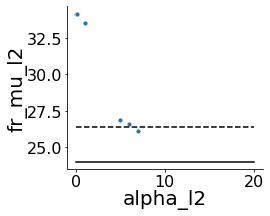

In [63]:
df = pd.read_json('/home/diego/storage/generative-glm/experiments/figure3/monkey_pmv/' + 'df_l2.pk')
ax = sns.scatterplot(x='alpha_l2', y='fr_mu_l2', data=df)
ax.plot([0, 20], [fr_train, fr_train], 'k-')
ax.plot([0, 20], [1.1 * fr_train, 1.1 * fr_train], 'k--')

In [114]:
dic = dict(basis=basis, alpha_l2=alpha_l2, u0_l2=glm_l2.u0, eta_coefs_l2=glm_l2.eta.coefs, fr_mu_l2=fr_mu_l2, fr_sd_l2=fr_sd_l2, 
           nll_normed_train_l2=nll_normed_train_l2, r_train_dc_l2=r_train_dc_l2, r_fr_l2_long=r_fr_l2_long, z_cum_l2=z_cum_l2,
           st_fr_l2_long=st_fr_l2_long, psth_l2=psth_l2, bins_ks=bins_ks, mmd_l2=mmd_l2, padding=padding, 
           isi_fr_l2_long=isi_fr_l2_long, autocov_l2_long=autocov_l2_long, lr=lr)

path = '/home/diego/storage/generative-glm/experiments/figure3/monkey_pmv/' + 'l2.pk'
with open(path, "wb") as fit_file:
    pickle.dump(dic, fit_file)

### CIMMD <a name="mmd"></a>  
[contents](#contents)

In [9]:
def fun_metrics_mmd(model, t, mask_spikes, mask_spikes_fr):
    dt = 1
    T_train = t[-1] - t[0] + t[1]
    mu_fr = np.mean(np.sum(mask_spikes_fr.double().numpy(), 0)) / T_train * 1000
    return dict(mu_fr=mu_fr)

In [10]:
path = '/home/diego/storage/generative-glm/experiments/figure3/monkey_pmv/' + 'ml.pk'
with open(path, "rb") as fit_file:
    dic_ml = pickle.load(fit_file)

u0_ml, eta_coefs_ml, bins_ks = dic_ml['u0_ml'], dic_ml['eta_coefs_ml'], dic_ml['bins_ks']
nll_normed_train_ml, z_cum_ml, isi_fr_ml_long = dic_ml['nll_normed_train_ml'], dic_ml['z_cum_ml'], dic_ml['isi_fr_ml_long']
autocov_ml_long = dic_ml['autocov_ml_long']
del dic_ml

eta_ml = KernelBasisValues(basis, [0, basis.shape[0]], 1, coefs=eta_coefs_ml)
glm_ml = TorchGLM(u0=u0_ml, eta=eta_ml)

In [15]:
# phi, kernel, lam_mmd, biased, lr, clip = phi_autocov, None, 5e3, True, 1e-2, 1e0
# phi, kernel, lam_mmd, biased, lr, clip = phi_autocov, None, 5e2, True, 1e-2, 1e0 # within 10%
phi, kernel, lam_mmd, biased, lr, clip = phi_autocov, None, 1.5e3, True, 1e-2, 1e0
kernel_kwargs = dict(padding=500)

beta0, beta1 = 0, 0
n_batch_fr = 60
n_metrics = 1
num_epochs = 600

time0 = time.time()
u00 = glm_ml.u0
eta0 = glm_ml.eta.copy()

mmdglm = CIMMDGLM(u0=u00, eta=eta0)
optim = Adam(mmdglm.parameters(), lr=lr, betas=(beta0, beta1))

dtime = datetime.now()
dtime = str(dtime.year) + '/' + str(dtime.month) + '/' + str(dtime.day) + '-' + str(dtime.hour) + ':' + str(dtime.minute) + ':' + str(dtime.second)

loss_mmd, nll_train, metrics_mmd = mmdglm.train(t, torch.from_numpy(mask_spikes_train), phi=phi, kernel=kernel, 
                                                log_likelihood=True, score_term=False,
                                               n_batch_fr=n_batch_fr, kernel_kwargs=kernel_kwargs, lam_mmd=lam_mmd, biased=biased, optim=optim, clip=clip, 
                                                num_epochs=num_epochs, 
                                              verbose=True, metrics=fun_metrics_mmd, n_metrics=n_metrics)
loss_mmd, nll_train = np.array(loss_mmd), np.array(nll_train)
nll_normed_train_mmd = (nll_train - nll_pois_proc_train) / np.log(2) / n_spk_train
metrics_mmd['mmd'] = np.array(metrics_mmd['mmd'])
iterations_mmd = np.arange(1, num_epochs + 1, 1)

_, r_dc_mmd = mmdglm.sample_conditioned(st_train.t, st_train.mask)

_, r_fr_mmd_long, mask_spikes_fr_mmd_long = mmdglm.sample(t_long, shape=(8000,))
st_fr_mmd_long = SpikeTrain(t_long, mask_spikes_fr_mmd_long)
psth_mmd = np.mean(st_fr_mmd_long.convolve(conv_ker), 1) * 1000
isi_fr_mmd_long = st_fr_mmd_long.isi_distribution()
mean_isi_fr_mmd_long = np.mean(isi_fr_mmd_long)
sd_isi_fr_mmd_long = np.mean(isi_fr_mmd_long)
fr_mmd = np.sum(mask_spikes_fr_mmd_long, 0) / (t_long[-1] + dt) * 1000
fr_sd_mmd = np.std(fr_mmd) / np.sqrt(len(fr_mmd))
fr_mean_mmd = np.mean(fr_mmd)
autocov_mmd_long = np.mean(auto_covariance(mask_spikes_fr_mmd_long, method='fft', 
                                           subtract_mean=False, stationary_signal=False, biased=False), 1)
z_mmd, ks_mmd = time_rescale_transform(dt, st_train.mask, r_dc_mmd)
values, bins_ks = np.histogram(np.concatenate(z_mmd), bins=bins_ks)
z_cum_mmd = np.append(0., np.cumsum(values) / np.sum(values))

phi_d_mmd = phi_autocov(t, torch.from_numpy(r_dc_mmd), mmdglm, padding=kernel_kwargs['padding'])
phi_fr_mmd = phi_autocov(t, torch.from_numpy(r_fr_mmd_long[:len(t)]), mmdglm, padding=kernel_kwargs['padding'])
mmd_mmd = (torch.sum((torch.mean(phi_d_mmd.detach(), 1) - torch.mean(phi_fr_mmd.detach(), 1))**2)).item()

time1 = time.time()
etime = (time1 - time0) / 60
print('\n', 'took', time1 - time0, 'seconds', (time1 - time0) / 60, 'minutes')

 epoch 599 of 600 loss 1123.6553163594
 took 258.0286886692047 seconds 4.300478144486745 minutes


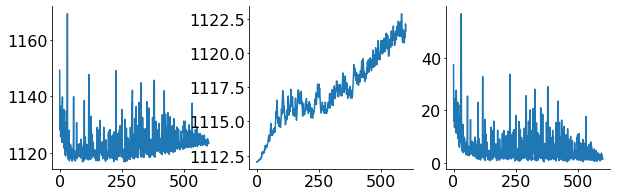

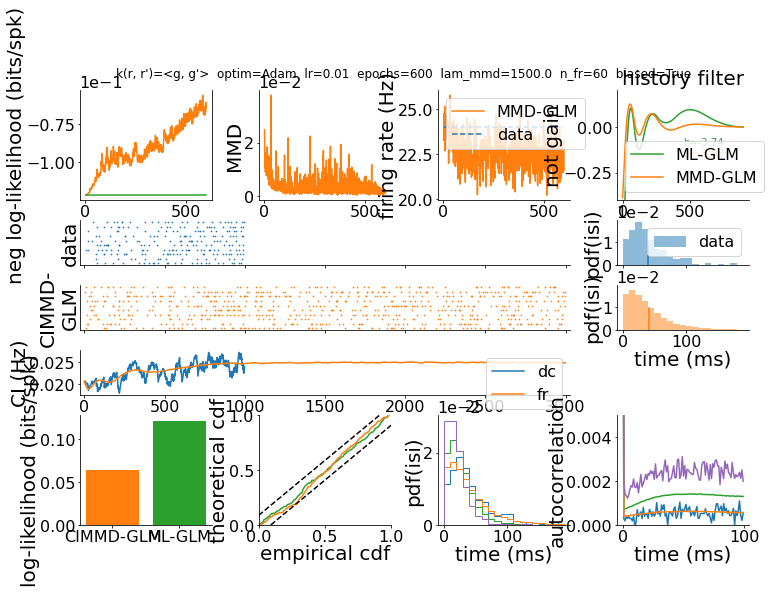

In [16]:
for key, val in metrics_mmd.items():
    metrics_mmd[key] = np.array(val)

if phi is not None:
    ker_name = phi.__name__
else:
    ker_name = kernel.__name__
    
title = "k(r, r')=" + dic_ker_strings[ker_name] + '  optim=' + str(optim.__class__.__name__) + '  lr=' + str(lr) \
     + '  epochs=' + str(num_epochs) + \
       '  lam_mmd=' + str(lam_mmd) + '  n_fr=' + str(n_batch_fr) + '  biased=' + str(biased)

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(10, 3), ncols=3)
ax1.plot(loss_mmd)
ax2.plot(nll_train)
ax3.plot((loss_mmd - nll_train))
# ax3.set_ylim(0, 1e4)

ncols = 4
r1, r2 = 2, 1
nrows = 2 * r1 + 3 * r2

# fig, (ax00, ax01, ax02, ax03, ax10, ax11, ax20, ax21, ax30, ax40, ax41, ax42, ax43) = plot_layout2(8)

fig = plt.figure(figsize=(12, 8))
ax00 = plt.subplot2grid((nrows, ncols), (0, 0), rowspan=r1)
ax01 = plt.subplot2grid((nrows, ncols), (0, 1), rowspan=r1, sharex=ax00)
ax02 = plt.subplot2grid((nrows, ncols), (0, 2), rowspan=r1, sharex=ax00)
ax03 = plt.subplot2grid((nrows, ncols), (0, 3), rowspan=r1)
ax10 = plt.subplot2grid((nrows, ncols), (r1, 0), colspan=ncols - 1)
ax11 = plt.subplot2grid((nrows, ncols), (r1, ncols - 1), colspan=1)
ax20 = plt.subplot2grid((nrows, ncols), (r1 + r2, 0), colspan=ncols - 1, sharex=ax10)
ax21 = plt.subplot2grid((nrows, ncols), (r1 + r2, ncols - 1), colspan=1, sharex=ax11, sharey=ax11)
ax30 = plt.subplot2grid((nrows, ncols), (r1 + 2*r2, 0), colspan=ncols - 1, sharex=ax10)
ax40 = plt.subplot2grid((nrows, ncols), (r1 + 3*r2, 0), rowspan=r1)
ax41 = plt.subplot2grid((nrows, ncols), (r1 + 3*r2, 1), rowspan=r1)
ax42 = plt.subplot2grid((nrows, ncols), (r1 + 3*r2, 2), rowspan=r1)
ax43 = plt.subplot2grid((nrows, ncols), (r1 + 3*r2, 3), rowspan=r1)

fig.suptitle(title, fontsize=12, y=0.92)

ax00.plot(iterations_mmd, nll_normed_train_mmd, '-', label='train', color=palette['mmd'])
ax00.plot([iterations_mmd[0], iterations_mmd[-1]], [nll_normed_train_mmd[0], nll_normed_train_mmd[0]], '-', 
          label='ML-GLM', color=palette['ml'])
ax00.spines['right'].set_visible(True)
ax00.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
# ax00.legend()
myplt.set_labels(ax00, xlabel='iterations', ylabel='neg log-likelihood (bits/spk)')

ax01.plot(iterations_mmd[::n_metrics], metrics_mmd['mmd'], label='MMD-GLM', color=palette['mmd'])
ax01.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
yf = np.median(metrics_mmd['mmd'][-10:] * 2)
# ax01.set_ylim(-1e2, yf)
myplt.set_labels(ax01, xlabel='iterations', ylabel='MMD')

ax02.plot(iterations_mmd[::n_metrics], metrics_mmd['mu_fr'], label='MMD-GLM', color=palette['mmd'])
ax02.plot([iterations_mmd[0], iterations_mmd[-1]], [fr_train, fr_train], '--', label='data', color=palette['d'])
myplt.set_labels(ax02, xlabel='iterations', ylabel='firing rate (Hz)')
ax02.legend()

glm_ml.eta.plot(t=t_ker, ax=ax03, exp_values=False, label='ML-GLM', color=palette['ml'])
mmdglm.eta.plot(t=t_ker, ax=ax03, exp_values=False, label='MMD-GLM', color=palette['mmd'])
myplt.set_labels(ax03, xlabel='time (ms)', ylabel='not gain', title='history filter')
ax03.text(0.5, 0.5, 'b=' + str(np.round(glm_ml.u0, 2)), color=palette['ml'], transform=ax03.transAxes)
ax03.text(0.5, 0.4, 'b=' + str(np.round(mmdglm.u0, 2)), color=palette['mmd'], transform=ax03.transAxes)
ax03.legend()
ax03.set_ylim(-0.4, 0.2)

ax11.hist(isi_train, density=True, alpha=0.5, color=palette['d'], label='data', bins=bins)
ax11.legend()
y1 = ax11.get_ylim()[1] / 2
ax11.plot([mean_isi_train, mean_isi_train], [0, y1], '-', color=palette['d'])
ax11.set_ylabel('pdf(isi)')
ax11.tick_params(axis='both', labelbottom=False)

ax21.hist(isi_fr_mmd_long, density=True, alpha=0.5, color=palette['mmd'], label='MMD-GLM', bins=bins)
ax21.plot([mean_isi_fr_mmd_long, mean_isi_fr_mmd_long], [0, y1], '-', color=palette['mmd'])
myplt.set_labels(ax21, xlabel='time (ms)', ylabel='pdf(isi)')
ax21.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

st_train.plot(ax=ax10, ms=0.7, color=palette['d'])
ax10.tick_params(axis='both', labelbottom=False, labelleft=False)
ax10.set_yticks([])
ax10.set_ylabel('data')

# st_fr_mmd.plot(ax=ax20, ms=0.7, color=palette['mmd'])
st_fr_mmd_long.sweeps(np.arange(10)).plot(ax=ax20, ms=0.7, color=palette['mmd'])
ax20.tick_params(axis='both', labelbottom=False, labelleft=False)
ax20.set_yticks([])
ax20.set_ylabel('CIMMD-\nGLM')

ax30.plot(t, np.mean(r_dc_mmd, 1), color=palette['d'], label='dc')
ax30.plot(t_long, np.mean(r_fr_mmd_long, 1), color=palette['mmd'], label='fr')
# ax30.plot(t_long, np.mean(r_train_dc_ml, 1), color=palette['ml'], label='ML-FR')
ax30.legend()
myplt.set_labels(ax30, xlabel='time (ms)', ylabel='CI (Hz)')

ax40.bar(0, -nll_normed_train_mmd[-1], color=palette['mmd'], label='CIMMD-GLM')
ax40.bar(1, -nll_normed_train_ml[-1], color=palette['ml'], label='ML-GLM')
# ax40.legend()
ax40.set_ylabel('log-likelihood (bits/spk)')
ax40.set_xticks([0, 1])
ax40.set_xticklabels(['CIMMD-GLM', 'ML-GLM'])

# ax40.set_ylabel('log-likelihood (bits/spk)')

ax41.plot(bins_ks, z_cum_ml, color=palette['ml'], label='ML-GLM')
ax41.plot(bins_ks, z_cum_mmd, color=palette['mmd'], label='CIMMD-GLM')
x = np.array([0, 1])
ax41.plot(x, x + 1.36 / np.sqrt(len(np.concatenate((z_mmd)))), 'k--')
ax41.plot(x, x - 1.36 / np.sqrt(len(np.concatenate((z_mmd)))), 'k--')
myplt.set_labels(ax41, xlabel='empirical cdf', ylabel='theoretical cdf')
ax41.set_xlim(0, 1); ax41.set_ylim(0, 1)
# ax41.text(0.5, 0.2, 'p=' + str(np.round(ks_ml[1], 2)), color=palette['ml'], transform=ax41.transAxes)
# ax41.text(0.5, 0.1, 'p=' + str(np.round(ks_mmd[1], 2)), color=palette['mmd'], transform=ax41.transAxes)

lw = 1
ax42.hist(isi_train, density=True, alpha=1, color=palette['d'], histtype='step', lw=lw, label='data', bins=bins)
ax42.hist(isi_fr_ml_long, density=True, alpha=1, color=palette['ml'], histtype='step', lw=lw, label='ML-GLM', bins=bins)
ax42.hist(isi_fr_mmd_long, density=True, alpha=1, color=palette['mmd'], histtype='step', lw=lw, label='CIMMD-GLM', bins=bins)
ax42.hist(isi_inh, density=True, alpha=1, color=palette['chen'], histtype='step', lw=lw, label='chen', bins=bins)
ax42.set_ylabel('pdf(isi)')
ax42.set_xlabel('time (ms)')
ax42.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
# ax42.legend()
# y1 = ax42.get_ylim()[1] / 2
# ax42.plot([mean_isi_train, mean_isi_train], [0, y1], '-', color=palette['d'])
# ax42.tick_params(axis='both', labelbottom=False)

ax43.plot(autocov_train[:argf_autocor], color=palette['d'], label='data')
ax43.plot(autocov_ml_long[:argf_autocor], color=palette['ml'], label='ML-GLM')
ax43.plot(autocov_mmd_long[:argf_autocor], color=palette['mmd'], label='MMD-GLM')
ax43.plot(autocov_inh[:argf_autocor], color=palette['chen'], label='chen')
ax43.set_ylim(0, 5e-3)
myplt.set_labels(ax43, xlabel='time (ms)', ylabel='autocorrelation')

# fig.subplots_adjust(hspace=0.35)
fig.subplots_adjust(hspace=0.45, wspace=0.35)

In [17]:
fig_name = 'cimmd_' + dic_ker_name[ker_name] + '_' + 'lammmd' + str(lam_mmd) + 'biased' + str(biased) +  '_epochs' + str(num_epochs) + '_' + 'lr' + str(lr)
file_name = fig_name

list_files = os.listdir('/home/diego/storage/generative-glm/experiments/figure3/monkey_pmv/')

ii = 1
while file_name + '_' + str(ii) + '.pk' in list_files:
    ii += 1
file_name = fig_name + '_' + str(ii) + '.pk'
# fig_name += '_' + str(ii) + '.pdf'

# # fig.savefig('/home/diego/storage/generative-glm/experiments/figure3/monkey_pmv/' + fig_name, transparent=True)

dic = dict(server=os.uname()[1], dtime=dtime, mmd_ker='model_based', ker_name=ker_name, 
           u0_ml=glm_ml.u0, eta_coefs_ml=glm_ml.eta.coefs, num_epochs=num_epochs, 
           lam_mmd=lam_mmd, biased=biased, lr=lr, beta0=beta0, beta1=beta1, clip=clip, 
           n_batch_fr=n_batch_fr, etime=etime, loss_mmd=loss_mmd, nll_train=nll_train, nll_normed_train=nll_normed_train_mmd,
           metrics_mmd=metrics_mmd, fr_mean_mmd=fr_mean_mmd, fr_max_mmd=np.max(fr_mmd), mmd_mmd=mmd_mmd, 
           u0_mmd=mmdglm.u0, eta_coefs_mmd=mmdglm.eta.coefs, padding=kernel_kwargs['padding'], 
           psth_mmd=psth_mmd, isi_fr_mmd_long=isi_fr_mmd_long, autocov_mmd_long=autocov_mmd_long)

path = '/home/diego/storage/generative-glm/experiments/figure3/monkey_pmv/' + file_name
with open(path, "wb") as fit_file:
    pickle.dump(dic, fit_file)

dic_df = dict(file_name=file_name, server=os.uname()[1], dtime=dtime, mmd_ker='model_based', ker_name=ker_name, 
              num_epochs=num_epochs, 
                lam_mmd=lam_mmd, biased=biased, lr=lr, beta0=beta0, beta1=beta1, clip=clip, n_batch_fr=n_batch_fr, etime=etime, 
              loss_mmd=loss_mmd[-1], 
                nll_train=nll_train[-1], nll_normed_train=nll_normed_train_mmd[-1], 
              fr_mean_mmd=fr_mean_mmd, fr_max_mmd=np.max(fr_mmd), mmd_mmd=mmd_mmd, 
              u0=mmdglm.u0, eta_coefs=mmdglm.eta.coefs, padding=kernel_kwargs['padding'])

_df = pd.DataFrame.from_dict(dic_df, orient='index').T
df = pd.read_json( '/home/diego/storage/generative-glm/experiments/figure3/monkey_pmv/' + 'df_mmd.json')
df = df.append(_df, ignore_index=True)
df.to_json( '/home/diego/storage/generative-glm/experiments/figure3/monkey_pmv/' + 'df_mmd.json')

In [17]:
# _df.to_json( '/home/diego/storage/generative-glm/experiments/figure3/monkey_pmv/' + 'df_mmd.json')

## paper figure <a name="paper_figure"></a>  
[contents](#contents)

#### load ml

In [11]:
path = '/home/diego/storage/generative-glm/experiments/figure3/monkey_pmv/' + 'ml.pk'
with open(path, "rb") as fit_file:
    dic_ml = pickle.load(fit_file)

u0_ml, eta_coefs_ml = dic_ml['u0_ml'], dic_ml['eta_coefs_ml']
nll_normed_train_ml = dic_ml['nll_normed_train_ml']
r_train_dc_ml, r_fr_ml_long = dic_ml['r_train_dc_ml'], dic_ml['r_fr_ml_long']
z_cum_ml = dic_ml['z_cum_ml']
st_fr_ml_long, isi_fr_ml_long = dic_ml['st_fr_ml_long'], dic_ml['isi_fr_ml_long']
autocov_ml_long = dic_ml['autocov_ml_long']
bins_ks = dic_ml['bins_ks']
mmd_ml = dic_ml['mmd_ml']
psth_ml = dic_ml['psth_ml']

eta_ml = KernelBasisValues(basis, [0, basis.shape[0]], 1, coefs=eta_coefs_ml)
glm_ml = TorchGLM(u0=u0_ml, eta=eta_ml)

#### load l2

In [111]:
path = '/home/diego/storage/generative-glm/experiments/figure3/monkey_pmv/' + 'l2.pk'
with open(path, "rb") as fit_file:
    dic_l2 = pickle.load(fit_file)

u0_l2, eta_coefs_l2 = dic_l2['u0_l2'], dic_l2['eta_coefs_l2']
nll_normed_train_l2 = dic_l2['nll_normed_train_l2']
r_train_dc_l2, r_fr_l2_long = dic_l2['r_train_dc_l2'], dic_l2['r_fr_l2_long']
z_cum_l2 = dic_l2['z_cum_l2']
st_fr_l2_long, isi_fr_l2_long = dic_l2['st_fr_l2_long'], dic_l2['isi_fr_l2_long']
autocov_l2_long = dic_l2['autocov_l2_long']
# bins_ks = dic_l2['bins_ks']
mmd_l2 = dic_l2['mmd_l2']
psth_l2 = dic_l2['psth_l2']

eta_l2 = KernelBasisValues(basis, [0, basis.shape[0]], 1, coefs=eta_coefs_l2)
glm_l2 = TorchGLM(u0=u0_l2, eta=eta_l2)

#### load mmd

In [141]:
path = '/home/diego/storage/generative-glm/experiments/figure3/monkey_pmv/'
df = pd.read_json('/home/diego/storage/generative-glm/experiments/figure3/monkey_pmv/' + 'df_mmd.json')

In [138]:
# df = df[(~df.file_name.isna()) & (df.beta1 == 0) & (df.num_epochs == 400) & (df.n_batch_fr == 60) & (df.lam_mmd == 1500) & (df.padding == 500)]
# df = df[(~df.file_name.isna()) & (df.beta1 == 0) & (df.num_epochs == 400) & (df.n_batch_fr == 60) & (df.lam_mmd == 5000) & (df.padding == 500)]
# df = df[(~df.file_name.isna()) & (df.beta1 == 0) & (df.num_epochs == 400) & (df.n_batch_fr == 60) & (df.lam_mmd == 500) & (df.padding == 700)]

In [139]:
# pk_files = [f for f in os.listdir(path) if f[-3:] == '.pk' and 'lammmd00.0' in f]
pk_files = list(df.file_name)

u0, eta_vals, eta_coefs, nll_train, mmd_mmd, autocov_mmd_long = [], [], [], [], [], []
for pkf in pk_files:
    with open(path + pkf, "rb") as file:
        dic = pickle.load(file)
#     _eta_vals = np.dot(dic['basis'], dic['eta_coefs_mmd'])
    _eta_vals = np.dot(basis, dic['eta_coefs_mmd'])
    eta_mmd = KernelBasisValues(basis, [0, basis.shape[0]], 1, coefs=dic['eta_coefs_mmd'])
    mmdglm = TorchGLM(u0=dic['u0_mmd'], eta=eta_mmd)
    _, r_dc_mmd = mmdglm.sample_conditioned(st_train.t, st_train.mask)
#     _, r_fr_mmd, mask_spikes_fr_mmd = mmdglm.sample(st_train.t, shape=(st_train.mask.shape[1],))
#     _, r_fr_mmd, mask_spikes_fr_mmd = mmdglm.sample(st_train.t, shape=(n_samples,))
#     phi_d_mmd = phi_autocov(t, torch.from_numpy(r_dc_mmd), mmdglm)
#     phi_fr_mmd = phi_autocov(t, torch.from_numpy(r_fr_mmd), mmdglm)
#     _mmd_mmd = (torch.sum((torch.mean(phi_d_mmd.detach(), 1) - torch.mean(phi_fr_mmd.detach(), 1))**2)).item()
    _mmd_mmd = dic['mmd_mmd']
#     _, _, mask_autocov = mmdglm.sample(t_long, shape=(400,))
#     _autocov_mmd_long = np.mean(auto_covariance(mask_autocov, method='fft', 
#                                            subtract_mean=False, stationary_signal=False, biased=False), 1)
    _autocov_mmd_long = dic['autocov_mmd_long']
    
    eta_vals.append(_eta_vals)
    u0.append(dic['u0_mmd'])
    eta_coefs.append(dic['eta_coefs_mmd'])
    nll_train.append(dic['nll_train'][-1])
    mmd_mmd.append(_mmd_mmd)
    autocov_mmd_long.append(_autocov_mmd_long[:argf_autocor] / _autocov_mmd_long[0])
    
eta_vals = np.stack(eta_vals, 1)
eta_coefs = np.stack(eta_coefs, 1)
autocov_mmd_long = np.stack(autocov_mmd_long, 1)
eta_vals_mean = np.mean(eta_vals, 1)
u0_mean = np.mean(u0)
eta_coefs_mean = np.mean(eta_coefs, 1)

ll_normed_train_mmd = -(nll_train - nll_pois_proc_train) / np.log(2) / n_spk_train

eta_vals0 = np.percentile(eta_vals, 2.5, axis=1)
eta_valsm = np.percentile(eta_vals, 50, axis=1)
eta_valsf = np.percentile(eta_vals, 97.5, axis=1)

autocov_mmd_long0 = np.percentile(autocov_mmd_long, 2.5, axis=1)
autocov_mmd_longm = np.percentile(autocov_mmd_long, 50, axis=1)
autocov_mmd_longf = np.percentile(autocov_mmd_long, 97.5, axis=1)

u0_m = np.exp(np.percentile(u0, 50)) * 1000
u0_0 = u0_m - np.exp(np.percentile(u0, 2.5)) * 1000
u0_f = np.exp(np.percentile(u0, 97.5)) * 1000 - u0_m

ll_normed_train_mmd_m = np.percentile(ll_normed_train_mmd, 50)
ll_normed_train_mmd_0 = ll_normed_train_mmd_m - np.percentile(ll_normed_train_mmd, 2.5)
ll_normed_train_mmd_f = np.percentile(ll_normed_train_mmd, 97.5) - ll_normed_train_mmd_m

mmd_mmd_m = np.percentile(mmd_mmd, 50)
mmd_mmd_0 = mmd_mmd_m - np.percentile(mmd_mmd, 2.5)
mmd_mmd_f = np.percentile(mmd_mmd, 97.5) - mmd_mmd_m

ValueError: need at least one array to stack

In [129]:
eta_mmd = KernelBasisValues(basis, [0, basis.shape[0]], 1, coefs=eta_coefs_mean)
mmdglm = TorchGLM(u0=u0_mean, eta=eta_mmd)
# loss_mmd = dic['loss_mmd']
# nll_train = dic['nll_train']
# nll_normed_train_mmd = (nll_train - nll_pois_proc_train) / np.log(2) / n_spk_train
# iterations_mmd = np.arange(1, len(loss_mmd) + 1, 1)

# _, r_dc_mmd = mmdglm.sample_conditioned(st_train.t, st_train.mask)
# _, r_fr_mmd, mask_spikes_fr_mmd = mmdglm.sample(st_train.t, shape=(st_train.mask.shape[1],))
# st_fr_mmd = SpikeTrain(st_train.t, mask_spikes_fr_mmd)
# isi_fr_mmd = st_fr_mmd.isi_distribution()
# mean_isi_fr_mmd = np.mean(isi_fr_mmd)

_, r_fr_mmd_long, mask_spikes_fr_mmd_long = mmdglm.sample(t_long, shape=(8000,))
st_fr_mmd_long = SpikeTrain(t_long, mask_spikes_fr_mmd_long)
# isi_fr_mmd_long = st_fr_mmd_long.isi_distribution()
# fr_mmd = np.sum(mask_spikes_fr_mmd_long, 0) / (t_long[-1] + dt) * 1000
# fr_sd_mmd = np.std(fr_mmd) / np.sqrt(len(fr_mmd))
# fr_mmd = np.mean(fr_mmd)
# mean_isi_fr_mmd_long = np.mean(isi_fr_mmd_long)
# _, _, mask_autocov = mmdglm.sample(t_long, shape=(400,))
# autocov_mmd_long = np.mean(auto_covariance(mask_autocov, method='fft', 
#                                            subtract_mean=False, stationary_signal=False, biased=False), 1)
# z_mmd, ks_mmd = time_rescale_transform(dt, st_train.mask, r_dc_mmd)
# values, bins_ks = np.histogram(np.concatenate(z_mmd), bins=bins_ks)
# z_cum_mmd = np.append(0., np.cumsum(values) / np.sum(values))

# psth_mmd = np.mean(st_fr_mmd_long.convolve(conv_ker), 1) * 1000

In [130]:
# psth_l2 = np.mean(st_fr_l2_long.convolve(conv_ker), 1) * 1000

# phi_d_l2 = phi_autocov(t, torch.from_numpy(r_train_dc_l2), glm_l2)
# phi_fr_l2 = phi_autocov(t, torch.from_numpy(r_fr_l2_long[:len(t)]), glm_l2)
# mmd_l2 = (torch.sum((torch.mean(phi_d_l2.detach(), 1) - torch.mean(phi_fr_l2.detach(), 1))**2)).item()

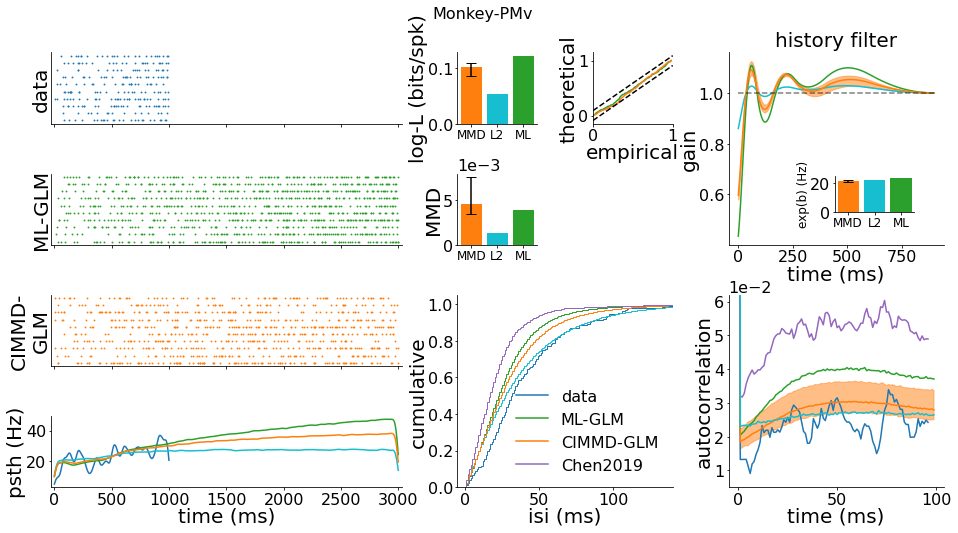

In [132]:
# fig, (axll, axpp, axeta, axd, axisi, axml, axmmd, axac, axpsth) = plot_layout2()
# fig.subplots_adjust(hspace=0.6, wspace=0.3)
# fig.suptitle('Monkey-PMv', fontsize=16, y=0.92)

tick_labelsize = 12

xlabels = ['MMD', 'L2', 'ML']

fig, (axd, axll, axmmds, axpp, axeta, axml, axmmd, axisi, axac, axpsth) = plot_layout3(8)
fig.subplots_adjust(hspace=0.7, wspace=0.7)
fig.suptitle('Monkey-PMv', fontsize=16, y=0.96)

# axll.bar(0, -nll_normed_train_mmd[-1], color=palette['mmd'], label='CIMMD-GLM')
axll.bar(0, ll_normed_train_mmd_m, color=palette['mmd'], label='MMD-GLM', yerr=np.array([ll_normed_train_mmd_0, ll_normed_train_mmd_f]).reshape(2, 1))
axll.bar(1, -nll_normed_train_l2[-1], color=palette['l2'], label='L2-GLM')
axll.bar(2, -nll_normed_train_ml[-1], color=palette['ml'], label='ML-GLM')
# axll.set_ylabel('log-likelihood (bits/spk)')
axll.set_ylabel('log-L (bits/spk)')
axll.set_xticks([0, 1, 2])
axll.set_xticklabels(xlabels, fontsize=tick_labelsize)

# axmmds.bar(0, mmd_mmd, color=palette['mmd'], label='CIMMD-GLM')
axmmds.bar(0, mmd_mmd_m, color=palette['mmd'], label='MMD-GLM', yerr=np.array([mmd_mmd_0, mmd_mmd_f]).reshape(2, 1))
axmmds.bar(1, mmd_l2, color=palette['l2'], label='L2-GLM')
axmmds.bar(2, mmd_ml, color=palette['ml'], label='ML-GLM')
# axll.set_ylabel('log-likelihood (bits/spk)')
axmmds.set_ylabel('MMD')
axmmds.set_xticks([0, 1, 2])
axmmds.set_xticklabels(xlabels, fontsize=tick_labelsize)
axmmds.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

axpp.plot(bins_ks, z_cum_ml, color=palette['ml'], label='ML-GLM')
axpp.plot(bins_ks, z_cum_mmd, color=palette['mmd'], label='CIMMD-GLM')
x = np.array([0, 1])
axpp.plot(x, x + 1.36 / np.sqrt(len(np.concatenate((z_mmd)))), 'k--')
axpp.plot(x, x - 1.36 / np.sqrt(len(np.concatenate((z_mmd)))), 'k--')
myplt.set_labels(axpp, xlabel='empirical', ylabel='theoretical')
axpp.set_xlim(0, 1); ax01.set_ylim(0, 1)
# axpp.text(0.5, 0.2, 'p=' + str(np.round(ks_ml[1], 2)), color=palette['ml'], transform=axpp.transAxes)
# axpp.text(0.5, 0.1, 'p=' + str(np.round(ks_mmd[1], 2)), color=palette['mmd'], transform=axpp.transAxes)

glm_ml.eta.plot(t=t_ker, ax=axeta, exp_values=True, label='ML-GLM', color=palette['ml'])
# mmdglm.eta.plot(t=t_ker, ax=axeta, exp_values=True, label='CIMMD-GLM', color=palette['mmd'])
glm_l2.eta.plot(t=t_ker, ax=axeta, exp_values=True, label='L2-GLM', color=palette['l2'])
axeta.plot(t_ker, np.exp(eta_valsm), label='CIMMD-GLM', color=palette['mmd'])
axeta.fill_between(t_ker, np.exp(eta_vals0), np.exp(eta_valsf), alpha=0.5, color=palette['mmd'])
myplt.set_labels(axeta, xlabel='time (ms)', ylabel='gain', title='history filter')
# axeta.text(0.5, 0.5, 'b=' + str(np.round(glm.u0, 2)), color=palette['ml'], transform=axeta.transAxes, fontsize=tick_labelsize)
# axeta.text(0.5, 0.4, 'b=' + str(np.round(mmdglm.u0, 2)), color=palette['mmd'], transform=axeta.transAxes, fontsize=tick_labelsize)
# axeta.legend(frameon=False)
axeta.plot([t_ker[0], t_ker[-1]], [1, 1], 'k--', alpha=0.5)

axbias = inset_axes(axeta, width=1.1, height=0.5, bbox_to_anchor=(0, 0.1, .9, .3),
                   bbox_transform=axeta.transAxes)
axbias.bar(0, u0_m, color=palette['mmd'], yerr=np.array([u0_0, u0_f]).reshape(2, 1))
axbias.bar(1, np.exp(glm_l2.u0) * 1000, color=palette['l2'])
axbias.bar(2, np.exp(glm_ml.u0) * 1000, color=palette['ml'])
axbias.set_ylabel('exp(b) (Hz)', fontsize=tick_labelsize)
axbias.set_xticks(range(3))
axbias.set_xticklabels(xlabels, fontsize=tick_labelsize)
space = 0.5
axbias.set_xlim(0 - space, 2 + space)

ms = 0.85
st_train.plot(ax=axd, ms=ms, color=palette['d'])
axd.tick_params(axis='both', labelbottom=False, labelleft=False)
axd.set_yticks([])
axd.set_ylabel('data')

st_fr_ml_long.sweeps(np.arange(10)).plot(ax=axml, ms=ms, color=palette['ml'])
axml.tick_params(axis='both', labelbottom=False, labelleft=False)
axml.set_yticks([])
axml.set_ylabel('ML-GLM')

lw = 1
axisi.plot([0], [0], color=palette['d'], label='data')
axisi.plot([0], [0], color=palette['ml'], label='ML-GLM')
axisi.plot([0], [0], color=palette['mmd'], label='CIMMD-GLM')
axisi.plot([0], [0], color=palette['chen'], label='Chen2019')
axisi.legend(loc='lower right', frameon=False)
bins = np.arange(0, 191, 1)
# bins = np.arange(0, 191, 10)
axisi.hist(isi_train, density=True, cumulative=True, alpha=1, color=palette['d'], histtype='step', lw=lw, label='data', bins=bins)
axisi.hist(isi_fr_ml_long, density=True, cumulative=True, alpha=1, color=palette['ml'], histtype='step', lw=lw, label='ML-GLM', bins=bins)
axisi.hist(isi_fr_l2_long, density=True, cumulative=True, alpha=1, color=palette['l2'], histtype='step', lw=lw, label='L2-GLM', bins=bins)
axisi.hist(isi_fr_mmd_long, density=True, cumulative=True, alpha=1, color=palette['mmd'], histtype='step', lw=lw, label='CIMMD-GLM', bins=bins)
axisi.hist(isi_inh, density=True, alpha=1, cumulative=True, color=palette['chen'], histtype='step', lw=lw, label='Chen2019', bins=bins)
axisi.set_ylabel('cumulative')
axisi.set_xlabel('isi (ms)')
# axisi.set_ylabel('pdf(isi)')
# axisi.set_xlabel('time (ms)')
axisi.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
axisi.set_xlim(-5, 140)
# myplt.remove_legend_handles_and_color_text(axisi)

st_fr_mmd_long.sweeps(np.arange(10)).plot(ax=axmmd, ms=ms, color=palette['mmd'])
axmmd.tick_params(axis='both', labelbottom=False, labelleft=False)
axmmd.set_yticks([])
axmmd.set_ylabel('CIMMD-\nGLM')

autocor_train = autocov_train[:argf_autocor] / autocov_train[0]
autocor_inh = autocov_inh[:argf_autocor] / autocov_inh[0]

# Smooth autocov
delta = 3
# ker_ma = KernelRect([-delta, delta + dt], coefs=[1 / (2 * delta)])
# autocor_train_smooth = ker_ma.convolve_continuous(t, autocor_train)
autocor_train_smooth = np.array([np.mean(autocor_train[ii - delta:ii + delta]) for ii in range(delta, len(autocor_train), 1)])
autocor_inh_smooth = np.array([np.mean(autocor_inh[ii - delta:ii + delta]) for ii in range(delta, len(autocor_inh), 1)])

alpha = 1
axac.plot(autocor_train_smooth, alpha=alpha, color=palette['d'], label='data')
axac.plot(autocov_ml_long[:argf_autocor] / autocov_ml_long[0], alpha=alpha, color=palette['ml'], label='ML-GLM')
axac.plot(np.arange(0, argf_autocor, 1), autocov_mmd_longm[:argf_autocor], label='CIMMD-GLM', color=palette['mmd'])
axac.fill_between(np.arange(0, argf_autocor, 1), autocov_mmd_long0[:argf_autocor], autocov_mmd_longf[:argf_autocor], alpha=0.5, color=palette['mmd'])
axac.plot(autocor_inh_smooth, alpha=alpha, color=palette['chen'], label='chen')
axac.plot(autocov_l2_long[:argf_autocor] / autocov_l2_long[0], alpha=alpha, color=palette['l2'], label='L2')
axac.set_ylim(0.005, 0.062)
myplt.set_labels(axac, xlabel='time (ms)', ylabel='autocorrelation')
axac.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

alpha = 1
axpsth.plot(t, psth_d, alpha=alpha, color=palette['d'])
axpsth.plot(t_long, psth_ml, alpha=alpha, color=palette['ml'])
axpsth.plot(t_long, psth_l2, alpha=alpha, color=palette['l2'])
axpsth.plot(t_long, psth_mmd, alpha=alpha, color=palette['mmd'])
myplt.set_labels(axpsth, xlabel='time (ms)', ylabel='firing rate (Hz)')
# ax40.plot(t, np.mean(r_dc_mmd, 1), alpha=alpha, color=palette['d'], label='dc')
# axpsth.plot(t_long, np.mean(r_fr_mmd_long, 1), alpha=alpha, color=palette['mmd'], label='fr')

# ax40.plot(t, np.mean(r_train_dc_ml, 1), '--', alpha=alpha, color=palette['d'], label='dc')
# axpsth.plot(t_long, np.mean(r_fr_ml_long, 1), alpha=alpha, color=palette['ml'], label='fr')
# ax40.plot(t, np.mean(r_dc_mmd, 1), color=palette['d'], label='dc')
# ax40.plot(t_long, np.mean(r_fr_mmd_long, 1), color=palette['mmd'], label='fr')
# ax40.legend()

# fig.savefig('./fig3.pdf', transparent=True)

## rebuttal figure

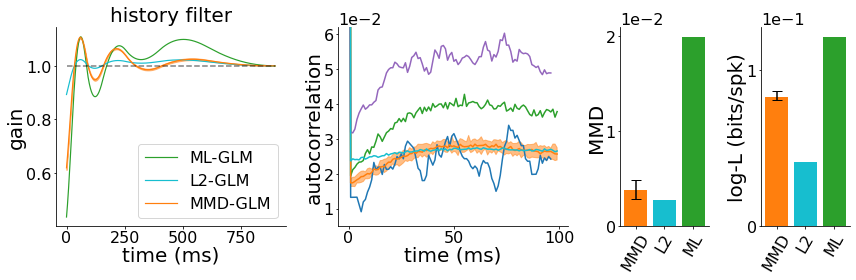

In [95]:
tick_labelsize = 16

f = 4
# fig, (axeta, axac, axmmd, axll) = plot_layout_rebuttal(f)
# fig.subplots_adjust(hspace=0.7, wspace=0.4)
fig, (axeta, axac, axmmd, axll) = plot_layout_rebuttal2(f)
fig.subplots_adjust(wspace=0.6)

lw = 1.2
glm.eta.plot(t=t_ker, ax=axeta, exp_values=True, label='ML-GLM', color=palette['ml'], lw=lw)
glm_l2.eta.plot(t=t_ker, ax=axeta, exp_values=True, label='L2-GLM', color=palette['l2'], lw=lw)
axeta.plot(t_ker, np.exp(eta_valsm), label='MMD-GLM', color=palette['mmd'], lw=lw)
axeta.fill_between(t_ker, np.exp(eta_vals0), np.exp(eta_valsf), alpha=0.5, color=palette['mmd'])
myplt.set_labels(axeta, xlabel='time (ms)', ylabel='gain', title='history filter')
axeta.plot([t_ker[0], t_ker[-1]], [1, 1], 'k--', alpha=0.5)
axeta.legend()

# axbias = inset_axes(axeta, width=1.2, height=0.5, bbox_to_anchor=(0, 0.1, .9, .3),
#                    bbox_transform=axeta.transAxes)
# axbias.bar(0, u0_m, color=palette['mmd'], yerr=np.array([u0_0, u0_f]).reshape(2, 1))
# axbias.bar(1, np.exp(glm_l2.u0) * 1000, color=palette['l2'])
# axbias.bar(2, np.exp(glm.u0) * 1000, color=palette['ml'])
# axbias.set_ylabel('exp(b) (Hz)', fontsize=tick_labelsize)
# axbias.set_xticks(range(3))
# axbias.set_xticklabels(xlabels, fontsize=tick_labelsize)
# space = 0.5
# axbias.set_xlim(0 - space, 2 + space)

alpha = 1
axac.plot(autocor_train_smooth, alpha=alpha, color=palette['d'], label='data')
axac.plot(autocov_ml_long[:argf_autocor] / autocov_ml_long[0], alpha=alpha, color=palette['ml'], label='ML-GLM')
axac.plot(np.arange(0, argf_autocor, 1), autocov_mmd_longm[:argf_autocor], label='MMD-GLM', color=palette['mmd'])
axac.fill_between(np.arange(0, argf_autocor, 1), autocov_mmd_long0[:argf_autocor], autocov_mmd_longf[:argf_autocor], alpha=0.5, color=palette['mmd'])
axac.plot(autocor_inh_smooth, alpha=alpha, color=palette['chen'], label='chen')
axac.plot(autocov_l2_long[:argf_autocor] / autocov_l2_long[0], alpha=alpha, color=palette['l2'], label='L2')
axac.set_ylim(0.005, 0.062)
myplt.set_labels(axac, xlabel='time (ms)', ylabel='autocorrelation')
axac.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

axmmd.bar(0, mmd_mmd_m, color=palette['mmd'], label='CIMMD-GLM', yerr=np.array([mmd_mmd_0, mmd_mmd_f]).reshape(2, 1))
axmmd.bar(1, mmd_l2, color=palette['l2'], label='L2-GLM')
axmmd.bar(2, mmd_ml, color=palette['ml'], label='ML-GLM')
axmmd.set_ylabel('MMD')
axmmd.set_xticks([0, 1, 2])
axmmd.set_xticklabels(xlabels, fontsize=tick_labelsize, rotation=60)
axmmd.set_yticks([0, 1e-2, 2e-2])
axmmd.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

axll.bar(0, ll_normed_train_mmd_m, color=palette['mmd'], label='CIMMD-GLM', yerr=np.array([ll_normed_train_mmd_0, ll_normed_train_mmd_f]).reshape(2, 1))
axll.bar(1, -nll_normed_train_l2[-1], color=palette['l2'], label='L2-GLM')
axll.bar(2, -nll_normed_train_ml[-1], color=palette['ml'], label='ML-GLM')
axll.set_ylabel('log-L (bits/spk)')
axll.set_xticks([0, 1, 2])
axll.set_xticklabels(xlabels, fontsize=tick_labelsize, rotation=60)
axll.set_yticks([0, 1e-1])
axll.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

fig.tight_layout()
fig.savefig('./fig3_rebuttal.pdf', transparent=True)

In [21]:
import itertools

lam_mmds = [1e3]
beta1s = [0]
paddings = [700]

pars = list(itertools.product(lam_mmds, beta1s, paddings))
pars = pars * 4

In [22]:
for lam_mmd, beta1, padding in pars:
    phi, kernel, biased, lr, clip = phi_autocov, None, True, 1e-2, 1e0
    kernel_kwargs = dict(padding=padding)

    beta0 = 0
    n_batch_fr = 60
    n_metrics = 1
    num_epochs = 400

    time0 = time.time()
    u00 = glm_ml.u0
    eta0 = glm_ml.eta.copy()

    mmdglm = CIMMDGLM(u0=u00, eta=eta0)
    optim = Adam(mmdglm.parameters(), lr=lr, betas=(beta0, beta1))

    dtime = datetime.now()
    dtime = str(dtime.year) + '/' + str(dtime.month) + '/' + str(dtime.day) + '-' + str(dtime.hour) + ':' + str(dtime.minute) + ':' + str(dtime.second)

    loss_mmd, nll_train, metrics_mmd = mmdglm.train(t, torch.from_numpy(mask_spikes_train), phi=phi, kernel=kernel, 
                                                    log_likelihood=True, score_term=False,
                                                   n_batch_fr=n_batch_fr, kernel_kwargs=kernel_kwargs, lam_mmd=lam_mmd, biased=biased, optim=optim, clip=clip, 
                                                    num_epochs=num_epochs, 
                                                  verbose=True, metrics=fun_metrics_mmd, n_metrics=n_metrics)
    loss_mmd, nll_train = np.array(loss_mmd), np.array(nll_train)
    nll_normed_train_mmd = (nll_train - nll_pois_proc_train) / np.log(2) / n_spk_train
    metrics_mmd['mmd'] = np.array(metrics_mmd['mmd'])
    iterations_mmd = np.arange(1, num_epochs + 1, 1)

    _, r_dc_mmd = mmdglm.sample_conditioned(st_train.t, st_train.mask)

    _, r_fr_mmd_long, mask_spikes_fr_mmd_long = mmdglm.sample(t_long, shape=(8000,))
    st_fr_mmd_long = SpikeTrain(t_long, mask_spikes_fr_mmd_long)
    psth_mmd = np.mean(st_fr_mmd_long.convolve(conv_ker), 1) * 1000
    isi_fr_mmd_long = st_fr_mmd_long.isi_distribution()
    mean_isi_fr_mmd_long = np.mean(isi_fr_mmd_long)
    sd_isi_fr_mmd_long = np.mean(isi_fr_mmd_long)
    fr_mmd = np.sum(mask_spikes_fr_mmd_long, 0) / (t_long[-1] + dt) * 1000
    fr_sd_mmd = np.std(fr_mmd) / np.sqrt(len(fr_mmd))
    fr_mean_mmd = np.mean(fr_mmd)
    autocov_mmd_long = np.mean(auto_covariance(mask_spikes_fr_mmd_long, method='fft', 
                                               subtract_mean=False, stationary_signal=False, biased=False), 1)
    z_mmd, ks_mmd = time_rescale_transform(dt, st_train.mask, r_dc_mmd)
    values, bins_ks = np.histogram(np.concatenate(z_mmd), bins=bins_ks)
    z_cum_mmd = np.append(0., np.cumsum(values) / np.sum(values))

    phi_d_mmd = phi_autocov(t, torch.from_numpy(r_dc_mmd), mmdglm, padding=kernel_kwargs['padding'])
    phi_fr_mmd = phi_autocov(t, torch.from_numpy(r_fr_mmd_long[:len(t)]), mmdglm, padding=kernel_kwargs['padding'])
    mmd_mmd = (torch.sum((torch.mean(phi_d_mmd.detach(), 1) - torch.mean(phi_fr_mmd.detach(), 1))**2)).item()

    time1 = time.time()
    etime = (time1 - time0) / 60
    print('\n', 'took', time1 - time0, 'seconds', (time1 - time0) / 60, 'minutes')

    for key, val in metrics_mmd.items():
        metrics_mmd[key] = np.array(val)

    if phi is not None:
        ker_name = phi.__name__
    else:
        ker_name = kernel.__name__

    title = "k(r, r')=" + dic_ker_strings[ker_name] + '  optim=' + str(optim.__class__.__name__) + '  lr=' + str(lr) \
         + '  epochs=' + str(num_epochs) + \
           '  lam_mmd=' + str(lam_mmd) + '  n_fr=' + str(n_batch_fr) + '  biased=' + str(biased)

    fig, (ax1, ax2, ax3) = plt.subplots(figsize=(10, 3), ncols=3)
    ax1.plot(loss_mmd)
    ax2.plot(nll_train)
    ax3.plot((loss_mmd - nll_train))
    # ax3.set_ylim(0, 1e4)

    ncols = 4
    r1, r2 = 2, 1
    nrows = 2 * r1 + 3 * r2

    # fig, (ax00, ax01, ax02, ax03, ax10, ax11, ax20, ax21, ax30, ax40, ax41, ax42, ax43) = plot_layout2(8)

    fig = plt.figure(figsize=(12, 8))
    ax00 = plt.subplot2grid((nrows, ncols), (0, 0), rowspan=r1)
    ax01 = plt.subplot2grid((nrows, ncols), (0, 1), rowspan=r1, sharex=ax00)
    ax02 = plt.subplot2grid((nrows, ncols), (0, 2), rowspan=r1, sharex=ax00)
    ax03 = plt.subplot2grid((nrows, ncols), (0, 3), rowspan=r1)
    ax10 = plt.subplot2grid((nrows, ncols), (r1, 0), colspan=ncols - 1)
    ax11 = plt.subplot2grid((nrows, ncols), (r1, ncols - 1), colspan=1)
    ax20 = plt.subplot2grid((nrows, ncols), (r1 + r2, 0), colspan=ncols - 1, sharex=ax10)
    ax21 = plt.subplot2grid((nrows, ncols), (r1 + r2, ncols - 1), colspan=1, sharex=ax11, sharey=ax11)
    ax30 = plt.subplot2grid((nrows, ncols), (r1 + 2*r2, 0), colspan=ncols - 1, sharex=ax10)
    ax40 = plt.subplot2grid((nrows, ncols), (r1 + 3*r2, 0), rowspan=r1)
    ax41 = plt.subplot2grid((nrows, ncols), (r1 + 3*r2, 1), rowspan=r1)
    ax42 = plt.subplot2grid((nrows, ncols), (r1 + 3*r2, 2), rowspan=r1)
    ax43 = plt.subplot2grid((nrows, ncols), (r1 + 3*r2, 3), rowspan=r1)

    fig.suptitle(title, fontsize=12, y=0.92)

    ax00.plot(iterations_mmd, nll_normed_train_mmd, '-', label='train', color=palette['mmd'])
    ax00.plot([iterations_mmd[0], iterations_mmd[-1]], [nll_normed_train_mmd[0], nll_normed_train_mmd[0]], '-', 
              label='ML-GLM', color=palette['ml'])
    ax00.spines['right'].set_visible(True)
    ax00.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    # ax00.legend()
    myplt.set_labels(ax00, xlabel='iterations', ylabel='neg log-likelihood (bits/spk)')

    ax01.plot(iterations_mmd[::n_metrics], metrics_mmd['mmd'], label='MMD-GLM', color=palette['mmd'])
    ax01.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    yf = np.median(metrics_mmd['mmd'][-10:] * 2)
    # ax01.set_ylim(-1e2, yf)
    myplt.set_labels(ax01, xlabel='iterations', ylabel='MMD')

    ax02.plot(iterations_mmd[::n_metrics], metrics_mmd['mu_fr'], label='MMD-GLM', color=palette['mmd'])
    ax02.plot([iterations_mmd[0], iterations_mmd[-1]], [fr_train, fr_train], '--', label='data', color=palette['d'])
    myplt.set_labels(ax02, xlabel='iterations', ylabel='firing rate (Hz)')
    ax02.legend()

    glm_ml.eta.plot(t=t_ker, ax=ax03, exp_values=False, label='ML-GLM', color=palette['ml'])
    mmdglm.eta.plot(t=t_ker, ax=ax03, exp_values=False, label='MMD-GLM', color=palette['mmd'])
    myplt.set_labels(ax03, xlabel='time (ms)', ylabel='not gain', title='history filter')
    ax03.text(0.5, 0.5, 'b=' + str(np.round(glm_ml.u0, 2)), color=palette['ml'], transform=ax03.transAxes)
    ax03.text(0.5, 0.4, 'b=' + str(np.round(mmdglm.u0, 2)), color=palette['mmd'], transform=ax03.transAxes)
    ax03.legend()
    ax03.set_ylim(-0.4, 0.2)

    ax11.hist(isi_train, density=True, alpha=0.5, color=palette['d'], label='data', bins=bins)
    ax11.legend()
    y1 = ax11.get_ylim()[1] / 2
    ax11.plot([mean_isi_train, mean_isi_train], [0, y1], '-', color=palette['d'])
    ax11.set_ylabel('pdf(isi)')
    ax11.tick_params(axis='both', labelbottom=False)

    ax21.hist(isi_fr_mmd_long, density=True, alpha=0.5, color=palette['mmd'], label='MMD-GLM', bins=bins)
    ax21.plot([mean_isi_fr_mmd_long, mean_isi_fr_mmd_long], [0, y1], '-', color=palette['mmd'])
    myplt.set_labels(ax21, xlabel='time (ms)', ylabel='pdf(isi)')
    ax21.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

    st_train.plot(ax=ax10, ms=0.7, color=palette['d'])
    ax10.tick_params(axis='both', labelbottom=False, labelleft=False)
    ax10.set_yticks([])
    ax10.set_ylabel('data')

    # st_fr_mmd.plot(ax=ax20, ms=0.7, color=palette['mmd'])
    st_fr_mmd_long.sweeps(np.arange(10)).plot(ax=ax20, ms=0.7, color=palette['mmd'])
    ax20.tick_params(axis='both', labelbottom=False, labelleft=False)
    ax20.set_yticks([])
    ax20.set_ylabel('CIMMD-\nGLM')

    ax30.plot(t, np.mean(r_dc_mmd, 1), color=palette['d'], label='dc')
    ax30.plot(t_long, np.mean(r_fr_mmd_long, 1), color=palette['mmd'], label='fr')
    # ax30.plot(t_long, np.mean(r_train_dc_ml, 1), color=palette['ml'], label='ML-FR')
    ax30.legend()
    myplt.set_labels(ax30, xlabel='time (ms)', ylabel='CI (Hz)')

    ax40.bar(0, -nll_normed_train_mmd[-1], color=palette['mmd'], label='CIMMD-GLM')
    ax40.bar(1, -nll_normed_train_ml[-1], color=palette['ml'], label='ML-GLM')
    # ax40.legend()
    ax40.set_ylabel('log-likelihood (bits/spk)')
    ax40.set_xticks([0, 1])
    ax40.set_xticklabels(['CIMMD-GLM', 'ML-GLM'])

    # ax40.set_ylabel('log-likelihood (bits/spk)')

    ax41.plot(bins_ks, z_cum_ml, color=palette['ml'], label='ML-GLM')
    ax41.plot(bins_ks, z_cum_mmd, color=palette['mmd'], label='CIMMD-GLM')
    x = np.array([0, 1])
    ax41.plot(x, x + 1.36 / np.sqrt(len(np.concatenate((z_mmd)))), 'k--')
    ax41.plot(x, x - 1.36 / np.sqrt(len(np.concatenate((z_mmd)))), 'k--')
    myplt.set_labels(ax41, xlabel='empirical cdf', ylabel='theoretical cdf')
    ax41.set_xlim(0, 1); ax41.set_ylim(0, 1)
    # ax41.text(0.5, 0.2, 'p=' + str(np.round(ks_ml[1], 2)), color=palette['ml'], transform=ax41.transAxes)
    # ax41.text(0.5, 0.1, 'p=' + str(np.round(ks_mmd[1], 2)), color=palette['mmd'], transform=ax41.transAxes)

    lw = 1
    ax42.hist(isi_train, density=True, alpha=1, color=palette['d'], histtype='step', lw=lw, label='data', bins=bins)
    ax42.hist(isi_fr_ml_long, density=True, alpha=1, color=palette['ml'], histtype='step', lw=lw, label='ML-GLM', bins=bins)
    ax42.hist(isi_fr_mmd_long, density=True, alpha=1, color=palette['mmd'], histtype='step', lw=lw, label='CIMMD-GLM', bins=bins)
    ax42.hist(isi_inh, density=True, alpha=1, color=palette['chen'], histtype='step', lw=lw, label='chen', bins=bins)
    ax42.set_ylabel('pdf(isi)')
    ax42.set_xlabel('time (ms)')
    ax42.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    # ax42.legend()
    # y1 = ax42.get_ylim()[1] / 2
    # ax42.plot([mean_isi_train, mean_isi_train], [0, y1], '-', color=palette['d'])
    # ax42.tick_params(axis='both', labelbottom=False)

    ax43.plot(autocov_train[:argf_autocor], color=palette['d'], label='data')
    ax43.plot(autocov_ml_long[:argf_autocor], color=palette['ml'], label='ML-GLM')
    ax43.plot(autocov_mmd_long[:argf_autocor], color=palette['mmd'], label='MMD-GLM')
    ax43.plot(autocov_inh[:argf_autocor], color=palette['chen'], label='chen')
    ax43.set_ylim(0, 5e-3)
    myplt.set_labels(ax43, xlabel='time (ms)', ylabel='autocorrelation')

    # fig.subplots_adjust(hspace=0.35)
    fig.subplots_adjust(hspace=0.45, wspace=0.35)

    fig_name = 'cimmd_' + dic_ker_name[ker_name] + '_' + 'lammmd' + str(lam_mmd) + 'biased' + str(biased) +  '_epochs' + str(num_epochs) + '_' + 'lr' + str(lr)
    file_name = fig_name

    list_files = os.listdir('/home/diego/storage/generative-glm/experiments/figure3/monkey_pmv/')

    ii = 1
    while file_name + '_' + str(ii) + '.pk' in list_files:
        ii += 1
    file_name = fig_name + '_' + str(ii) + '.pk'
    # fig_name += '_' + str(ii) + '.pdf'

    # # fig.savefig('/home/diego/storage/generative-glm/experiments/figure3/monkey_pmv/' + fig_name, transparent=True)

    plt.close('all')
    
    dic = dict(server=os.uname()[1], dtime=dtime, mmd_ker='model_based', ker_name=ker_name, 
               u0_ml=glm_ml.u0, eta_coefs_ml=glm_ml.eta.coefs, num_epochs=num_epochs, 
               lam_mmd=lam_mmd, biased=biased, lr=lr, beta0=beta0, beta1=beta1, clip=clip, 
               n_batch_fr=n_batch_fr, etime=etime, loss_mmd=loss_mmd, nll_train=nll_train, nll_normed_train=nll_normed_train_mmd,
               metrics_mmd=metrics_mmd, fr_mean_mmd=fr_mean_mmd, fr_max_mmd=np.max(fr_mmd), mmd_mmd=mmd_mmd, 
               u0_mmd=mmdglm.u0, eta_coefs_mmd=mmdglm.eta.coefs, padding=kernel_kwargs['padding'], 
               psth_mmd=psth_mmd, isi_fr_mmd_long=isi_fr_mmd_long, autocov_mmd_long=autocov_mmd_long)

    path = '/home/diego/storage/generative-glm/experiments/figure3/monkey_pmv/' + file_name
    with open(path, "wb") as fit_file:
        pickle.dump(dic, fit_file)

    dic_df = dict(file_name=file_name, server=os.uname()[1], dtime=dtime, mmd_ker='model_based', ker_name=ker_name, 
                  num_epochs=num_epochs, 
                    lam_mmd=lam_mmd, biased=biased, lr=lr, beta0=beta0, beta1=beta1, clip=clip, n_batch_fr=n_batch_fr, etime=etime, 
                  loss_mmd=loss_mmd[-1], 
                    nll_train=nll_train[-1], nll_normed_train=nll_normed_train_mmd[-1], 
                  fr_mean_mmd=fr_mean_mmd, fr_max_mmd=np.max(fr_mmd), mmd_mmd=mmd_mmd, 
                  u0=mmdglm.u0, eta_coefs=mmdglm.eta.coefs, padding=kernel_kwargs['padding'])

    _df = pd.DataFrame.from_dict(dic_df, orient='index').T
    df = pd.read_json( '/home/diego/storage/generative-glm/experiments/figure3/monkey_pmv/' + 'df_mmd.json')
    df = df.append(_df, ignore_index=True)
    df.to_json( '/home/diego/storage/generative-glm/experiments/figure3/monkey_pmv/' + 'df_mmd.json')

 epoch 399 of 400 loss 1126.1643437643
 took 293.19753193855286 seconds 4.886625532309214 minutes
 epoch 399 of 400 loss 1123.1786955283
 took 278.8037509918213 seconds 4.646729183197022 minutes
 epoch 399 of 400 loss 1124.5505680391
 took 290.539115190506 seconds 4.842318586508433 minutes
 epoch 399 of 400 loss 1122.5322539017
 took 294.777973651886 seconds 4.912966227531433 minutes


In [51]:
df.etime.mean() * 30 / 60 * 5

5.908222433387493